In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline
%matplotlib qt

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


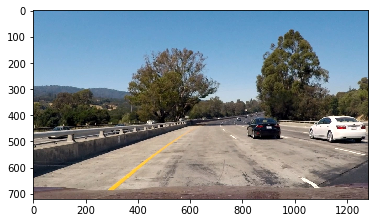

In [2]:
image = mpimg.imread('test_images/test1.jpg')/255
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [3]:
def hls_conversion (image):

    """
    creating the h, l and s channels of hls image from an image
    
    inputs:
        image
    outputs:
        hls
        h_channel
        l_channel
        s_channel
    """
#outimageHSV = np.uint8(outimageHSV)
#outimageBGR = cv2.cvtColor(outimageHSV, cv2.COLOR_HSV2BGR)

    img = np.copy(image)
    img = np.uint8(img)
    #plt.imshow(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    return (hls, h_channel, l_channel, s_channel)

In [4]:
def Camera_calib():
    """"
    
    inputs:
    
    outputs:
        corners
        ret
        mtx
        dist
        rvecs
        tvecs
    """
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    #Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    #images = glob.glob('../camera_cal/calibration*.jpg')
    img_chessboard = []
    image_chess = mpimg.imread('camera_cal/calibration2.jpg')
    #img = []
    #Step through the list and search for chessboard corners
    #for fname in images:
    #img = cv2.imread(fname)
    gray = cv2.cvtColor(image_chess,cv2.COLOR_BGR2GRAY)

    #Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    print(ret)
    #If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        #Draw and display the corners
        img_chessboard = cv2.drawChessboardCorners(image_chess, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    
    return img_chessboard, corners, ret, mtx, dist, rvecs, tvecs
#img_chessboard, corners, ret, mtx, dist, rvecs, tvecs = Camera_calib()
#print(img)
#plt.imshow(img_chessboard)

In [5]:
def undistort (img, mtx, dist):

    """
    
    inputs:
    
    outputs:
        dst
    """
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


In [6]:
def find_sobels(image, l_channel, s_channel, s_thresh=(110, 255), sx_thresh=(0, 255), sy_thresh=(0, 255), mag_thresh=(0, 255), dir_thresh=(0, np.pi/2)):

    """
    applying a color threshold in the HLS color space to detect the lanes

    inputs:
        image
        l_channel
        s_channel
        s_thresh
        sx_thresh
        sy_thresh
        mag_thresh
        dir_thresh
    outputs:
        color_binary_x
        color_binary_y
        mag_binary
        direction_binary
        s_binary_color
    """
    #img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.uint8(image)
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    #sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_x = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from horizontal
    scaled_sobel_y = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    abs_sobel = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    mag_sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    abs_mag_sobel = np.absolute(mag_sobel)
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel_x)
    sxbinary[(scaled_sobel_x >= sx_thresh[0]) & (scaled_sobel_x <= sx_thresh[1])] = 1
    
    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobel_y)
    sybinary[(scaled_sobel_y >= sy_thresh[0]) & (scaled_sobel_y <= sy_thresh[1])] = 1
    
    # Threshold color channel
    s_binary_color = np.zeros_like(s_channel)
    s_binary_color[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    #color_binary_x = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    #color_binary_y = np.dstack(( np.zeros_like(sybinary), sybinary, s_binary)) * 255
    
    scaled_magnitude = np.uint8(255*abs_mag_sobel/np.max(abs_mag_sobel))
    mag_binary = np.zeros_like(scaled_magnitude)
    mag_binary[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1
    
    direction_binary = np.zeros_like(arctan)
    direction_binary[(arctan >= dir_thresh[0]) & (arctan <= dir_thresh[1])] = 1
    
    #return color_binary_x, color_binary_y, mag_binary, direction_binary
    return sxbinary, sybinary, mag_binary, direction_binary, s_binary_color


In [7]:
def combined_sobel(sxbinary, sybinary, mag_binary, direction_binary, s_binary_color):

    """
    combination of diferent gradient measurements
    
    inputs:
        sxbinary
        sybinary
        mag_binary
        direction_binary
        s_binary_color
    outputs:
        combined_all
    """
    
    combined_no_col = np.zeros_like(direction_binary)
    combined_no_col[((sxbinary == 1) & (sybinary == 1)) | ((mag_binary == 1) & (direction_binary == 1))] = 1
    
    combined_all = np.zeros_like(combined_no_col)
    combined_all[(combined_no_col == 1) | (s_binary_color == 1)] = 1
    
    return combined_all

In [8]:
def hist(warped_trans):
    """
    calculating the histogram of image
    
    inputs:
        warped_trans
    outputs:
        histogram
        leftx_current
        rightx_current
    """
    #histogram = np.sum(warped_trans[warped_trans.shape[0]//2:,:], axis=0)
    bottom_half = warped_trans[warped_trans.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    #plt.plot(histogram)
    
    hist_mp = np.int(histogram.shape[0]//2)
    leftx_current = np.argmax(histogram[:hist_mp])
    rightx_current = np.argmax(histogram[hist_mp:]) + hist_mp
    
    return histogram, leftx_current, rightx_current



In [9]:
def find_lane_pixle(binary_warped, leftx_current, rightx_current):

    """
    
    inputs:
        binary_warped
        leftx_current
        rightx_current
    outputs:
        leftx
        lefty
        rightx
        righty
        out_img
    """
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


In [10]:
def image_tansformation(image, image_size, corners):

    """
    inputs:
        image
        image_size
        corners
    outputs:
        warped
        ransform_matrix
    """
    #defining the corner of source region
    #print(image_size)
    offset = 100
    
    src_corner_ul = [590, 450]
    src_corner_ur = [700, 450]
    src_cornre_ll = [200, 670]
    src_corner_lr = [1100, 700]

    #src_corner_ul = [image_size[0]//2, 450]
    #src_corner_ur = [(image_size[0]//2)+offset, 450]
    #src_cornre_ll = [200, image_size[1]]
    #src_corner_lr = [1000, image_size[1]]
    #print((image_size[0]//2)+offset)
    dst_corner_ul = [200, 0]
    dst_corner_ur = [1000, 0]
    dst_corner_ll = [200, 700]
    dst_corner_lr = [1000, 700]

    src_region = np.float32([src_corner_ul, src_cornre_ll, src_corner_ur, src_corner_lr])
    dst_region = np.float32([dst_corner_ul, dst_corner_ll, dst_corner_ur, dst_corner_lr])
    #print(src_region, 'src')
    #print(dst_region, 'dst')
    
    transform_matrix = []
    transform_matrix = cv2.getPerspectiveTransform(src_region, dst_region)
    warped = []
    warped = cv2.warpPerspective(image, transform_matrix, image_size)
    
    
    return (warped, transform_matrix)

#corners, ret, mtx, dist, rvecs, tvecs, img_chessboard = Camera_calib()
#image_size = (image.shape[1], image.shape[0])    
#warped, transform_matrix = image_tansformation(image, image_size, corners)  
#print(transform_matrix)
#f, (axim1, axim2) = plt.subplots(1,2, figsize=(20,10))
#axim1.imshow(image)
#axim2.imshow(warped)
#plt.imshow(warped)

In [11]:
def fit_polynomial(leftx, lefty, rightx, righty, out_img, binary_warped):

    """
    
    inputs:
        leftx
        lefty
        rightx
        righty
        out_img
        binary_warped
    outputs:
        out_img
        ploty
        left_fitx
        right_fitx
    """
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print(left_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='red')
    #plt.plot(right_fitx, ploty, color='red')

    return out_img, ploty, left_fitx, right_fitx



In [12]:
def curvature_not_center_calc(binary_warped, ploty, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix):

    """
    
    inputs:
        binary_warped
        ploty
        leftx
        lefty
        rightx
        righty
        xm_per_pix
        ym_per_pix
    outputs:
        left_curverad
        right_curverad
        left_fit
        right_fit
        y_val
    
    """
    
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1+(2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**(3/2))/np.absolute(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**(3/2))/np.absolute(2*right_fit[0])  ## Implement the calculation of the right line here
    
    
    return left_curverad, right_curverad, left_fit, right_fit, y_eval



In [13]:
def calc_veh_center(binary_warped, left_fit, right_fit, y_eval, xm_per_pix):

    """
    
    inputs:
        binary_warped
        left_fit
        right_fit
        y_val
        xm_pix
    outputs:
        center_txt
    """
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = binary_warped.shape[1]//2
    #print(center_image)
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    position = "left" if center < 0 else "right"
    center_txt = "Vehicle is {:.2f}m {}".format(center, position)
    
    # Now our radius of curvature is in meters
    return center_txt

In [14]:
def draw_on_image(undist_img, warped_trans, left_fitx, right_fitx, transform_matrix, left_curverad, right_curverad, center_txt):
    
    """
    
    inputs:
        undist_img
        warped_trans
        left_fitx
        right_fitx
        transform_matrix
        left_curverad
        right_curverad
        center_txt
    outputs:
        final_img
    """
    
    ploty = np.linspace(0, warped_trans.shape[0]-1, warped_trans.shape[0] )

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_trans).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(transform_matrix)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    final_img = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    cv2.putText(final_img, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(final_img, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(final_img, '{}'.format(center_txt), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
        
    return final_img


In [15]:

def myPipeline (binary_warped):
    
    """
    
    inputs:
        binary_warped
    outputs:
        out_img
        warped_trans
        transform_matrix
        ploty, left_curverad
        right_curverad
        left_fitx
        right_fitx
        center_txt
        
    """
    #reading image
    
    #binary_warped = mpimg.imread(image_file)/255
    image_size = (binary_warped.shape[1], binary_warped.shape[0])
    
    #calibration, undistortion
    img_chessboard, corners, ret, mtx, dist, rvecs, tvecs = Camera_calib()
    image_undistored = undistort (binary_warped, mtx, dist) * 255
    
    #plt.imshow(image_undistored)
    #cv2.imshow("", image_undistored.astype('float32'))
    # color transformation
    hls, h_channel, l_channel, s_channel = hls_conversion(image_undistored)
    sxbinary, sybinary, mag_binary, direction_binary, s_binary_color = find_sobels(image_undistored, l_channel, s_channel, sx_thresh=(20, 80), sy_thresh=(20, 100), mag_thresh=(20, 60), dir_thresh=(0, np.pi/32))
    #binary_image = combined_sobel(color_binary_x, color_binary_y, mag_binary, direction_binary)
    combined_all = combined_sobel(sxbinary, sybinary, mag_binary, direction_binary, s_binary_color)

    #histogram
    #warped_trans, transform_matrix = image_tansformation(binary_warped, image_size, corners)
    warped_trans, transform_matrix = image_tansformation(combined_all, image_size, corners)
    hist_image, leftx_current, rightx_current = hist(warped_trans)
    
    #print(transform_matrix)
    
    #print(leftx_current, ' ', rightx_current)

    leftx, lefty, rightx, righty, out_img = find_lane_pixle(warped_trans, leftx_current, rightx_current)
    out_img, ploty, left_fitx, right_fitx = fit_polynomial(leftx, lefty, rightx, righty, out_img, warped_trans)
    
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    image_matrix = []
    left_curverad, right_curverad, left_fit, right_fit, y_eval = curvature_not_center_calc(out_img, ploty, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix)
    center_txt= calc_veh_center(binary_warped, left_fit, right_fit, y_eval, xm_per_pix)
    image_matrix.append(out_img)
    return out_img, warped_trans, transform_matrix, ploty, left_curverad, right_curverad, left_fitx, right_fitx, center_txt

image = mpimg.imread('test_images/test1.jpg')
out_img, warped_trans, transform_matrix, ploty, left_curverad, right_curverad, left_fitx, right_fitx, center_txt = myPipeline(image)
#plt.plot(right_fitx)
print(transform_matrix)


True
[[ -5.70618627e-01  -1.48340464e+00   9.88807789e+02]
 [  2.06703341e-16  -1.89631666e+00   8.53342498e+02]
 [ -1.10080759e-05  -2.37878152e-03   1.00000000e+00]]


In [22]:
def image_process(image):
    
    """
    
    inputs:
        image_name
    outputs:
        final_img
    """
    
    #plt.imshow(image)
    out_img, warped_trans, transform_matrix, ploty, left_curverad, right_curverad, left_fitx, right_fitx, center_txt = myPipeline(image)
    final_img = draw_on_image(image, warped_trans, left_fitx, right_fitx, transform_matrix, left_curverad, right_curverad, center_txt)
    
    #final_img = np.uint8(final_img)
    return final_img #final_image_uint8

True
True
True
True
True
True


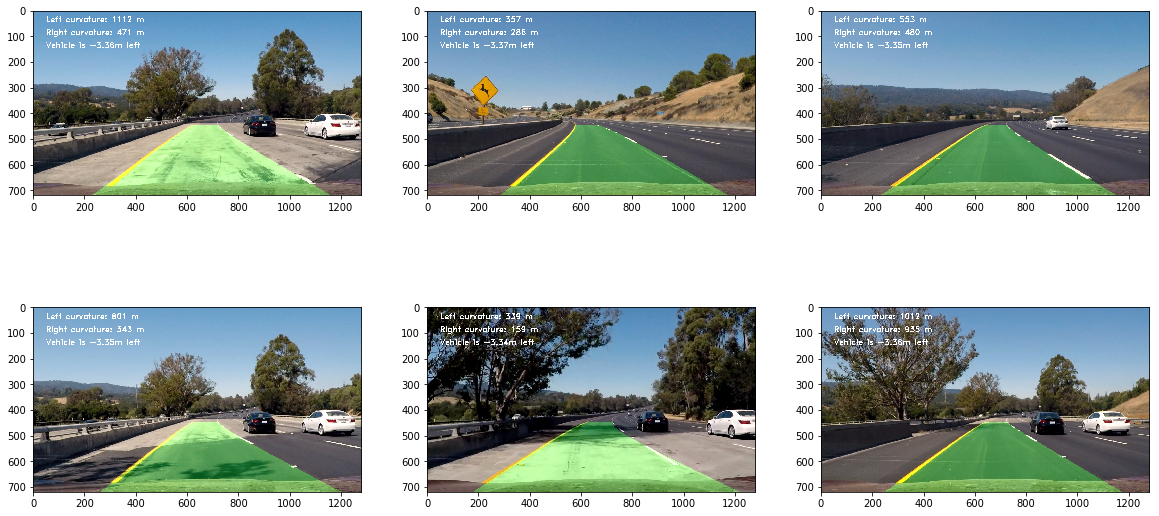

In [23]:
image_adress = 'test_images'
image_array = ['test1.jpg', 'test2.jpg','test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']

image_matrix = []
f, ((axim1, axim2, axim3), (axim4, axim5, axim6)) = plt.subplots(2,3, figsize=(20,10))
axim = [axim1, axim2, axim3, axim4, axim5, axim6]
img_idx = 0
for image_file in image_array:
    image_name = image_adress+'/'+image_file
    image = mpimg.imread(image_name)
    final_img = image_process(image)
    
    axim[img_idx].imshow(final_img)
    axim[img_idx].set_title = image_name
    img_idx +=1

In [26]:

white_output = "output_video/project_video.mp4"
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip(input_video).subclip(0,5)
white_clip = clip1.fl_image(image_process)
%time white_clip.write_videofile(white_output, audio=False)


True


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_video/project_video.mp4.
Moviepy - Writing video output_video/project_video.mp4



t:   0%|          | 2/1260 [00:02<24:04,  1.15s/it, now=None]

True
True


t:   0%|          | 3/1260 [00:05<35:43,  1.71s/it, now=None]

True


t:   0%|          | 4/1260 [00:09<50:59,  2.44s/it, now=None]

True


t:   0%|          | 5/1260 [00:11<51:23,  2.46s/it, now=None]

True


t:   0%|          | 6/1260 [00:13<46:20,  2.22s/it, now=None]

True


t:   1%|          | 8/1260 [00:17<43:11,  2.07s/it, now=None]

True


t:   1%|          | 9/1260 [00:19<40:55,  1.96s/it, now=None]

True


t:   1%|          | 10/1260 [00:21<40:25,  1.94s/it, now=None]

True


t:   1%|          | 11/1260 [00:22<39:12,  1.88s/it, now=None]

True


t:   1%|          | 12/1260 [00:24<37:25,  1.80s/it, now=None]

True
True


t:   1%|          | 13/1260 [00:26<36:29,  1.76s/it, now=None]

True


t:   1%|          | 14/1260 [00:27<37:00,  1.78s/it, now=None]

True


t:   1%|          | 15/1260 [00:30<42:26,  2.05s/it, now=None]

True


t:   1%|▏         | 17/1260 [00:34<41:33,  2.01s/it, now=None]

True
True


t:   1%|▏         | 18/1260 [00:36<38:23,  1.85s/it, now=None]

True


t:   2%|▏         | 19/1260 [00:37<37:40,  1.82s/it, now=None]

True


t:   2%|▏         | 21/1260 [00:41<38:21,  1.86s/it, now=None]

True


t:   2%|▏         | 22/1260 [00:43<37:24,  1.81s/it, now=None]

True


t:   2%|▏         | 23/1260 [00:45<37:53,  1.84s/it, now=None]

True


t:   2%|▏         | 24/1260 [00:47<43:09,  2.10s/it, now=None]

True
True


t:   2%|▏         | 25/1260 [00:53<1:02:21,  3.03s/it, now=None]

True


t:   2%|▏         | 27/1260 [00:57<53:15,  2.59s/it, now=None]  

True


t:   2%|▏         | 28/1260 [00:59<47:08,  2.30s/it, now=None]

True


t:   2%|▏         | 29/1260 [01:00<43:41,  2.13s/it, now=None]

True
True


t:   2%|▏         | 31/1260 [01:04<39:16,  1.92s/it, now=None]

True
True


t:   3%|▎         | 32/1260 [01:06<39:24,  1.93s/it, now=None]

True


t:   3%|▎         | 34/1260 [01:09<36:32,  1.79s/it, now=None]

True


t:   3%|▎         | 35/1260 [01:11<36:12,  1.77s/it, now=None]

True


t:   3%|▎         | 36/1260 [01:13<35:11,  1.72s/it, now=None]

True


t:   3%|▎         | 37/1260 [01:14<34:06,  1.67s/it, now=None]

True


t:   3%|▎         | 38/1260 [01:16<33:17,  1.63s/it, now=None]

True


t:   3%|▎         | 39/1260 [01:17<33:22,  1.64s/it, now=None]

True
True


t:   3%|▎         | 41/1260 [01:20<32:42,  1.61s/it, now=None]

True
True


t:   3%|▎         | 43/1260 [01:24<32:36,  1.61s/it, now=None]

True


t:   3%|▎         | 44/1260 [01:25<31:39,  1.56s/it, now=None]

True
True


t:   4%|▎         | 46/1260 [01:28<32:20,  1.60s/it, now=None]

True
True


t:   4%|▎         | 47/1260 [01:30<32:05,  1.59s/it, now=None]

True


t:   4%|▍         | 49/1260 [01:33<32:05,  1.59s/it, now=None]

True


t:   4%|▍         | 50/1260 [01:35<32:07,  1.59s/it, now=None]

True


t:   4%|▍         | 51/1260 [01:36<32:43,  1.62s/it, now=None]

True


t:   4%|▍         | 52/1260 [01:38<32:34,  1.62s/it, now=None]

True
True


t:   4%|▍         | 54/1260 [01:41<30:40,  1.53s/it, now=None]

True
True


t:   4%|▍         | 55/1260 [01:42<27:20,  1.36s/it, now=None]

True


t:   4%|▍         | 56/1260 [01:42<21:52,  1.09s/it, now=None]

True


t:   5%|▍         | 58/1260 [01:45<22:53,  1.14s/it, now=None]

True


t:   5%|▍         | 59/1260 [01:46<21:59,  1.10s/it, now=None]

True
True


t:   5%|▍         | 61/1260 [01:48<22:33,  1.13s/it, now=None]

True
True


t:   5%|▌         | 63/1260 [01:51<24:51,  1.25s/it, now=None]

True


t:   5%|▌         | 64/1260 [01:52<25:09,  1.26s/it, now=None]

True


t:   5%|▌         | 65/1260 [01:53<25:42,  1.29s/it, now=None]

True


t:   5%|▌         | 66/1260 [01:55<26:04,  1.31s/it, now=None]

True


t:   5%|▌         | 67/1260 [01:56<25:55,  1.30s/it, now=None]

True


t:   5%|▌         | 68/1260 [01:57<24:04,  1.21s/it, now=None]

True


t:   5%|▌         | 69/1260 [01:58<22:50,  1.15s/it, now=None]

True


t:   6%|▌         | 70/1260 [01:59<21:54,  1.10s/it, now=None]

True
True


t:   6%|▌         | 72/1260 [02:01<20:32,  1.04s/it, now=None]

True


t:   6%|▌         | 73/1260 [02:02<20:31,  1.04s/it, now=None]

True


t:   6%|▌         | 74/1260 [02:03<20:21,  1.03s/it, now=None]

True


t:   6%|▌         | 75/1260 [02:04<19:52,  1.01s/it, now=None]

True


t:   6%|▌         | 76/1260 [02:05<20:06,  1.02s/it, now=None]

True


t:   6%|▌         | 77/1260 [02:06<20:34,  1.04s/it, now=None]

True


t:   6%|▌         | 78/1260 [02:07<20:18,  1.03s/it, now=None]

True


t:   6%|▋         | 79/1260 [02:08<20:02,  1.02s/it, now=None]

True


t:   6%|▋         | 80/1260 [02:09<19:54,  1.01s/it, now=None]

True


t:   6%|▋         | 81/1260 [02:10<20:07,  1.02s/it, now=None]

True
True


t:   7%|▋         | 83/1260 [02:12<19:48,  1.01s/it, now=None]

True


t:   7%|▋         | 84/1260 [02:13<19:39,  1.00s/it, now=None]

True


t:   7%|▋         | 85/1260 [02:14<20:18,  1.04s/it, now=None]

True


t:   7%|▋         | 86/1260 [02:15<20:19,  1.04s/it, now=None]

True


t:   7%|▋         | 87/1260 [02:16<19:31,  1.00it/s, now=None]

True


t:   7%|▋         | 88/1260 [02:17<18:47,  1.04it/s, now=None]

True


t:   7%|▋         | 89/1260 [02:18<17:39,  1.11it/s, now=None]

True


t:   7%|▋         | 90/1260 [02:19<16:55,  1.15it/s, now=None]

True


t:   7%|▋         | 91/1260 [02:19<16:11,  1.20it/s, now=None]

True


t:   7%|▋         | 92/1260 [02:20<15:15,  1.28it/s, now=None]

True


t:   7%|▋         | 93/1260 [02:21<14:40,  1.33it/s, now=None]

True


t:   7%|▋         | 94/1260 [02:21<14:02,  1.38it/s, now=None]

True


t:   8%|▊         | 95/1260 [02:22<13:21,  1.45it/s, now=None]

True


t:   8%|▊         | 96/1260 [02:22<12:35,  1.54it/s, now=None]

True


t:   8%|▊         | 97/1260 [02:23<12:13,  1.59it/s, now=None]

True


t:   8%|▊         | 98/1260 [02:24<11:41,  1.66it/s, now=None]

True


t:   8%|▊         | 99/1260 [02:24<11:11,  1.73it/s, now=None]

True


t:   8%|▊         | 100/1260 [02:25<11:00,  1.76it/s, now=None]

True


t:   8%|▊         | 101/1260 [02:25<10:59,  1.76it/s, now=None]

True


t:   8%|▊         | 102/1260 [02:26<10:22,  1.86it/s, now=None]

True


t:   8%|▊         | 103/1260 [02:26<10:00,  1.93it/s, now=None]

True


t:   8%|▊         | 104/1260 [02:27<10:06,  1.91it/s, now=None]

True


t:   8%|▊         | 105/1260 [02:27<09:50,  1.96it/s, now=None]

True


t:   8%|▊         | 106/1260 [02:28<09:29,  2.02it/s, now=None]

True


t:   8%|▊         | 107/1260 [02:28<09:15,  2.08it/s, now=None]

True


t:   9%|▊         | 108/1260 [02:29<09:08,  2.10it/s, now=None]

True


t:   9%|▊         | 109/1260 [02:29<09:12,  2.08it/s, now=None]

True


t:   9%|▊         | 110/1260 [02:30<09:10,  2.09it/s, now=None]

True


t:   9%|▉         | 111/1260 [02:30<08:57,  2.14it/s, now=None]

True


t:   9%|▉         | 112/1260 [02:30<08:53,  2.15it/s, now=None]

True


t:   9%|▉         | 113/1260 [02:31<08:43,  2.19it/s, now=None]

True


t:   9%|▉         | 114/1260 [02:31<08:44,  2.19it/s, now=None]

True


t:   9%|▉         | 115/1260 [02:32<08:46,  2.17it/s, now=None]

True


t:   9%|▉         | 116/1260 [02:32<08:39,  2.20it/s, now=None]

True


t:   9%|▉         | 117/1260 [02:33<08:31,  2.24it/s, now=None]

True


t:   9%|▉         | 118/1260 [02:33<08:38,  2.20it/s, now=None]

True


t:   9%|▉         | 119/1260 [02:34<08:33,  2.22it/s, now=None]

True


t:  10%|▉         | 120/1260 [02:34<08:31,  2.23it/s, now=None]

True


t:  10%|▉         | 121/1260 [02:34<08:22,  2.27it/s, now=None]

True
True


t:  10%|▉         | 123/1260 [02:35<08:30,  2.23it/s, now=None]

True


t:  10%|▉         | 124/1260 [02:36<08:33,  2.21it/s, now=None]

True
True


t:  10%|█         | 126/1260 [02:37<08:54,  2.12it/s, now=None]

True


t:  10%|█         | 127/1260 [02:37<08:44,  2.16it/s, now=None]

True


t:  10%|█         | 128/1260 [02:38<08:35,  2.19it/s, now=None]

True


t:  10%|█         | 129/1260 [02:38<08:25,  2.24it/s, now=None]

True


t:  10%|█         | 130/1260 [02:39<08:12,  2.30it/s, now=None]

True


t:  10%|█         | 131/1260 [02:39<08:21,  2.25it/s, now=None]

True


t:  10%|█         | 132/1260 [02:39<08:17,  2.27it/s, now=None]

True


t:  11%|█         | 133/1260 [02:40<10:34,  1.78it/s, now=None]

True


t:  11%|█         | 134/1260 [02:41<09:49,  1.91it/s, now=None]

True


t:  11%|█         | 135/1260 [02:41<09:31,  1.97it/s, now=None]

True


t:  11%|█         | 136/1260 [02:42<09:09,  2.04it/s, now=None]

True


t:  11%|█         | 137/1260 [02:42<08:50,  2.12it/s, now=None]

True


t:  11%|█         | 138/1260 [02:42<08:31,  2.19it/s, now=None]

True


t:  11%|█         | 139/1260 [02:43<08:20,  2.24it/s, now=None]

True


t:  11%|█         | 140/1260 [02:43<08:16,  2.26it/s, now=None]

True


t:  11%|█         | 141/1260 [02:44<08:08,  2.29it/s, now=None]

True


t:  11%|█▏        | 142/1260 [02:44<08:10,  2.28it/s, now=None]

True


t:  11%|█▏        | 143/1260 [02:45<08:11,  2.27it/s, now=None]

True


t:  11%|█▏        | 144/1260 [02:45<08:20,  2.23it/s, now=None]

True


t:  12%|█▏        | 145/1260 [02:46<08:25,  2.21it/s, now=None]

True


t:  12%|█▏        | 146/1260 [02:46<08:24,  2.21it/s, now=None]

True


t:  12%|█▏        | 147/1260 [02:46<08:21,  2.22it/s, now=None]

True


t:  12%|█▏        | 148/1260 [02:47<08:21,  2.22it/s, now=None]

True


t:  12%|█▏        | 149/1260 [02:47<08:35,  2.15it/s, now=None]

True
True


t:  12%|█▏        | 151/1260 [02:48<08:20,  2.22it/s, now=None]

True


t:  12%|█▏        | 152/1260 [02:49<08:20,  2.21it/s, now=None]

True


t:  12%|█▏        | 153/1260 [02:49<08:22,  2.20it/s, now=None]

True


t:  12%|█▏        | 154/1260 [02:50<08:23,  2.20it/s, now=None]

True


t:  12%|█▏        | 155/1260 [02:50<08:25,  2.18it/s, now=None]

True


t:  12%|█▏        | 156/1260 [02:51<08:22,  2.20it/s, now=None]

True


t:  12%|█▏        | 157/1260 [02:51<08:14,  2.23it/s, now=None]

True


t:  13%|█▎        | 158/1260 [02:51<08:06,  2.26it/s, now=None]

True


t:  13%|█▎        | 159/1260 [02:52<08:13,  2.23it/s, now=None]

True


t:  13%|█▎        | 160/1260 [02:52<08:13,  2.23it/s, now=None]

True


t:  13%|█▎        | 161/1260 [02:53<07:52,  2.32it/s, now=None]

True


t:  13%|█▎        | 162/1260 [02:53<07:27,  2.45it/s, now=None]

True


t:  13%|█▎        | 163/1260 [02:53<07:08,  2.56it/s, now=None]

True


t:  13%|█▎        | 164/1260 [02:54<07:01,  2.60it/s, now=None]

True


t:  13%|█▎        | 165/1260 [02:54<07:23,  2.47it/s, now=None]

True


t:  13%|█▎        | 166/1260 [02:55<07:36,  2.40it/s, now=None]

True


t:  13%|█▎        | 167/1260 [02:55<07:52,  2.31it/s, now=None]

True


t:  13%|█▎        | 168/1260 [02:56<07:24,  2.45it/s, now=None]

True


t:  13%|█▎        | 169/1260 [02:56<07:12,  2.52it/s, now=None]

True


t:  13%|█▎        | 170/1260 [02:56<07:02,  2.58it/s, now=None]

True


t:  14%|█▎        | 171/1260 [02:57<06:55,  2.62it/s, now=None]

True


t:  14%|█▎        | 172/1260 [02:57<06:51,  2.65it/s, now=None]

True


t:  14%|█▎        | 173/1260 [02:57<06:51,  2.64it/s, now=None]

True


t:  14%|█▍        | 174/1260 [02:58<06:39,  2.72it/s, now=None]

True


t:  14%|█▍        | 175/1260 [02:58<06:38,  2.72it/s, now=None]

True


t:  14%|█▍        | 176/1260 [02:58<06:36,  2.73it/s, now=None]

True


t:  14%|█▍        | 177/1260 [02:59<06:46,  2.67it/s, now=None]

True


t:  14%|█▍        | 178/1260 [02:59<07:01,  2.57it/s, now=None]

True


t:  14%|█▍        | 179/1260 [03:00<07:34,  2.38it/s, now=None]

True


t:  14%|█▍        | 180/1260 [03:00<08:03,  2.23it/s, now=None]

True
True


t:  14%|█▍        | 182/1260 [03:01<08:30,  2.11it/s, now=None]

True


t:  15%|█▍        | 183/1260 [03:02<08:46,  2.04it/s, now=None]

True


t:  15%|█▍        | 184/1260 [03:02<08:31,  2.10it/s, now=None]

True


t:  15%|█▍        | 185/1260 [03:03<08:20,  2.15it/s, now=None]

True


t:  15%|█▍        | 186/1260 [03:03<07:43,  2.32it/s, now=None]

True


t:  15%|█▍        | 187/1260 [03:03<07:25,  2.41it/s, now=None]

True


t:  15%|█▍        | 188/1260 [03:04<07:24,  2.41it/s, now=None]

True


t:  15%|█▌        | 189/1260 [03:04<07:30,  2.38it/s, now=None]

True


t:  15%|█▌        | 190/1260 [03:05<07:29,  2.38it/s, now=None]

True


t:  15%|█▌        | 191/1260 [03:05<07:55,  2.25it/s, now=None]

True


t:  15%|█▌        | 192/1260 [03:06<07:45,  2.29it/s, now=None]

True


t:  15%|█▌        | 193/1260 [03:06<08:18,  2.14it/s, now=None]

True


t:  15%|█▌        | 194/1260 [03:07<08:30,  2.09it/s, now=None]

True


t:  15%|█▌        | 195/1260 [03:07<09:29,  1.87it/s, now=None]

True


t:  16%|█▌        | 196/1260 [03:08<09:27,  1.88it/s, now=None]

True


t:  16%|█▌        | 197/1260 [03:08<09:35,  1.85it/s, now=None]

True


t:  16%|█▌        | 198/1260 [03:09<09:16,  1.91it/s, now=None]

True


t:  16%|█▌        | 199/1260 [03:09<08:50,  2.00it/s, now=None]

True
True


t:  16%|█▌        | 200/1260 [03:10<09:18,  1.90it/s, now=None]

True


t:  16%|█▌        | 202/1260 [03:12<11:55,  1.48it/s, now=None]

True


t:  16%|█▌        | 203/1260 [03:12<11:12,  1.57it/s, now=None]

True
True


t:  16%|█▌        | 204/1260 [03:13<11:06,  1.58it/s, now=None]

True


t:  16%|█▋        | 206/1260 [03:14<10:41,  1.64it/s, now=None]

True


t:  16%|█▋        | 207/1260 [03:15<10:00,  1.75it/s, now=None]

True


t:  17%|█▋        | 208/1260 [03:15<09:07,  1.92it/s, now=None]

True


t:  17%|█▋        | 209/1260 [03:15<08:42,  2.01it/s, now=None]

True


t:  17%|█▋        | 210/1260 [03:16<08:13,  2.13it/s, now=None]

True


t:  17%|█▋        | 211/1260 [03:16<07:53,  2.21it/s, now=None]

True


t:  17%|█▋        | 212/1260 [03:17<07:34,  2.31it/s, now=None]

True


t:  17%|█▋        | 213/1260 [03:17<07:35,  2.30it/s, now=None]

True


t:  17%|█▋        | 214/1260 [03:17<07:33,  2.30it/s, now=None]

True


t:  17%|█▋        | 215/1260 [03:18<07:40,  2.27it/s, now=None]

True


t:  17%|█▋        | 216/1260 [03:18<07:32,  2.31it/s, now=None]

True


t:  17%|█▋        | 217/1260 [03:19<07:16,  2.39it/s, now=None]

True


t:  17%|█▋        | 218/1260 [03:19<07:15,  2.39it/s, now=None]

True


t:  17%|█▋        | 219/1260 [03:20<07:15,  2.39it/s, now=None]

True


t:  17%|█▋        | 220/1260 [03:20<07:13,  2.40it/s, now=None]

True


t:  18%|█▊        | 221/1260 [03:20<07:19,  2.36it/s, now=None]

True


t:  18%|█▊        | 222/1260 [03:21<07:19,  2.36it/s, now=None]

True


t:  18%|█▊        | 223/1260 [03:21<07:13,  2.39it/s, now=None]

True


t:  18%|█▊        | 224/1260 [03:22<07:03,  2.45it/s, now=None]

True


t:  18%|█▊        | 225/1260 [03:22<06:58,  2.47it/s, now=None]

True


t:  18%|█▊        | 226/1260 [03:22<06:59,  2.46it/s, now=None]

True


t:  18%|█▊        | 227/1260 [03:23<07:15,  2.37it/s, now=None]

True


t:  18%|█▊        | 228/1260 [03:23<07:19,  2.35it/s, now=None]

True


t:  18%|█▊        | 229/1260 [03:24<07:25,  2.32it/s, now=None]

True


t:  18%|█▊        | 230/1260 [03:24<07:26,  2.31it/s, now=None]

True


t:  18%|█▊        | 231/1260 [03:25<07:10,  2.39it/s, now=None]

True


t:  18%|█▊        | 232/1260 [03:25<07:00,  2.45it/s, now=None]

True


t:  18%|█▊        | 233/1260 [03:25<06:57,  2.46it/s, now=None]

True


t:  19%|█▊        | 234/1260 [03:26<06:48,  2.51it/s, now=None]

True


t:  19%|█▊        | 235/1260 [03:26<06:49,  2.50it/s, now=None]

True


t:  19%|█▊        | 236/1260 [03:27<06:50,  2.49it/s, now=None]

True


t:  19%|█▉        | 237/1260 [03:27<07:05,  2.40it/s, now=None]

True


t:  19%|█▉        | 238/1260 [03:27<06:55,  2.46it/s, now=None]

True


t:  19%|█▉        | 239/1260 [03:28<06:51,  2.48it/s, now=None]

True


t:  19%|█▉        | 240/1260 [03:28<06:58,  2.44it/s, now=None]

True


t:  19%|█▉        | 241/1260 [03:29<06:59,  2.43it/s, now=None]

True


t:  19%|█▉        | 242/1260 [03:29<07:00,  2.42it/s, now=None]

True


t:  19%|█▉        | 243/1260 [03:29<07:07,  2.38it/s, now=None]

True


t:  19%|█▉        | 244/1260 [03:30<06:54,  2.45it/s, now=None]

True


t:  19%|█▉        | 245/1260 [03:30<06:49,  2.48it/s, now=None]

True


t:  20%|█▉        | 246/1260 [03:31<06:47,  2.49it/s, now=None]

True


t:  20%|█▉        | 247/1260 [03:31<06:45,  2.50it/s, now=None]

True


t:  20%|█▉        | 248/1260 [03:31<06:55,  2.44it/s, now=None]

True


t:  20%|█▉        | 249/1260 [03:32<07:04,  2.38it/s, now=None]

True


t:  20%|█▉        | 250/1260 [03:32<07:11,  2.34it/s, now=None]

True


t:  20%|█▉        | 251/1260 [03:33<07:17,  2.31it/s, now=None]

True


t:  20%|██        | 252/1260 [03:33<07:18,  2.30it/s, now=None]

True


t:  20%|██        | 253/1260 [03:34<07:23,  2.27it/s, now=None]

True


t:  20%|██        | 254/1260 [03:34<07:24,  2.26it/s, now=None]

True


t:  20%|██        | 255/1260 [03:35<07:20,  2.28it/s, now=None]

True


t:  20%|██        | 256/1260 [03:35<07:25,  2.25it/s, now=None]

True


t:  20%|██        | 257/1260 [03:35<07:20,  2.27it/s, now=None]

True


t:  20%|██        | 258/1260 [03:36<07:24,  2.26it/s, now=None]

True


t:  21%|██        | 259/1260 [03:36<07:36,  2.19it/s, now=None]

True


t:  21%|██        | 260/1260 [03:37<07:29,  2.23it/s, now=None]

True


t:  21%|██        | 261/1260 [03:37<07:18,  2.28it/s, now=None]

True


t:  21%|██        | 262/1260 [03:38<07:16,  2.29it/s, now=None]

True


t:  21%|██        | 263/1260 [03:38<07:31,  2.21it/s, now=None]

True


t:  21%|██        | 264/1260 [03:39<07:31,  2.20it/s, now=None]

True


t:  21%|██        | 265/1260 [03:39<07:22,  2.25it/s, now=None]

True


t:  21%|██        | 266/1260 [03:39<07:16,  2.28it/s, now=None]

True
True


t:  21%|██▏       | 268/1260 [03:40<07:20,  2.25it/s, now=None]

True


t:  21%|██▏       | 269/1260 [03:41<07:17,  2.27it/s, now=None]

True


t:  21%|██▏       | 270/1260 [03:41<07:08,  2.31it/s, now=None]

True


t:  22%|██▏       | 271/1260 [03:42<07:22,  2.23it/s, now=None]

True


t:  22%|██▏       | 272/1260 [03:42<07:23,  2.23it/s, now=None]

True


t:  22%|██▏       | 273/1260 [03:43<07:18,  2.25it/s, now=None]

True


t:  22%|██▏       | 274/1260 [03:43<07:17,  2.25it/s, now=None]

True


t:  22%|██▏       | 275/1260 [03:43<07:19,  2.24it/s, now=None]

True


t:  22%|██▏       | 276/1260 [03:44<07:22,  2.22it/s, now=None]

True


t:  22%|██▏       | 277/1260 [03:44<07:11,  2.28it/s, now=None]

True


t:  22%|██▏       | 278/1260 [03:45<07:13,  2.27it/s, now=None]

True
True


t:  22%|██▏       | 280/1260 [03:46<07:05,  2.30it/s, now=None]

True


t:  22%|██▏       | 281/1260 [03:46<07:04,  2.31it/s, now=None]

True


t:  22%|██▏       | 282/1260 [03:47<07:07,  2.29it/s, now=None]

True


t:  22%|██▏       | 283/1260 [03:47<07:16,  2.24it/s, now=None]

True


t:  23%|██▎       | 284/1260 [03:47<07:09,  2.27it/s, now=None]

True


t:  23%|██▎       | 285/1260 [03:48<07:02,  2.31it/s, now=None]

True


t:  23%|██▎       | 286/1260 [03:48<07:01,  2.31it/s, now=None]

True


t:  23%|██▎       | 287/1260 [03:49<07:06,  2.28it/s, now=None]

True


t:  23%|██▎       | 288/1260 [03:49<07:08,  2.27it/s, now=None]

True


t:  23%|██▎       | 289/1260 [03:50<07:04,  2.29it/s, now=None]

True


t:  23%|██▎       | 290/1260 [03:50<07:00,  2.31it/s, now=None]

True


t:  23%|██▎       | 291/1260 [03:50<06:58,  2.32it/s, now=None]

True


t:  23%|██▎       | 292/1260 [03:51<07:08,  2.26it/s, now=None]

True


t:  23%|██▎       | 293/1260 [03:51<07:08,  2.26it/s, now=None]

True


t:  23%|██▎       | 294/1260 [03:52<06:59,  2.30it/s, now=None]

True


t:  23%|██▎       | 295/1260 [03:52<07:06,  2.26it/s, now=None]

True


t:  23%|██▎       | 296/1260 [03:53<07:11,  2.24it/s, now=None]

True


t:  24%|██▎       | 297/1260 [03:53<07:13,  2.22it/s, now=None]

True


t:  24%|██▎       | 298/1260 [03:54<07:13,  2.22it/s, now=None]

True


t:  24%|██▎       | 299/1260 [03:54<07:11,  2.23it/s, now=None]

True


t:  24%|██▍       | 300/1260 [03:55<07:15,  2.21it/s, now=None]

True


t:  24%|██▍       | 301/1260 [03:55<07:19,  2.18it/s, now=None]

True
True


t:  24%|██▍       | 303/1260 [03:56<07:08,  2.23it/s, now=None]

True


t:  24%|██▍       | 304/1260 [03:56<07:06,  2.24it/s, now=None]

True


t:  24%|██▍       | 305/1260 [03:57<07:06,  2.24it/s, now=None]

True


t:  24%|██▍       | 306/1260 [03:57<07:04,  2.25it/s, now=None]

True
True


t:  24%|██▍       | 307/1260 [03:58<07:13,  2.20it/s, now=None]

True


t:  24%|██▍       | 308/1260 [03:58<06:39,  2.38it/s, now=None]

True


t:  25%|██▍       | 309/1260 [03:58<06:12,  2.55it/s, now=None]

True


t:  25%|██▍       | 311/1260 [03:59<06:14,  2.53it/s, now=None]

True


t:  25%|██▍       | 312/1260 [04:00<06:33,  2.41it/s, now=None]

True
True


t:  25%|██▍       | 314/1260 [04:00<06:39,  2.37it/s, now=None]

True


t:  25%|██▌       | 315/1260 [04:01<06:42,  2.35it/s, now=None]

True


t:  25%|██▌       | 316/1260 [04:01<06:41,  2.35it/s, now=None]

True


t:  25%|██▌       | 317/1260 [04:02<06:42,  2.34it/s, now=None]

True


t:  25%|██▌       | 318/1260 [04:02<06:48,  2.31it/s, now=None]

True


t:  25%|██▌       | 319/1260 [04:03<06:48,  2.30it/s, now=None]

True


t:  25%|██▌       | 320/1260 [04:03<06:48,  2.30it/s, now=None]

True


t:  25%|██▌       | 321/1260 [04:03<06:49,  2.29it/s, now=None]

True


t:  26%|██▌       | 322/1260 [04:04<06:56,  2.25it/s, now=None]

True


t:  26%|██▌       | 323/1260 [04:04<07:00,  2.23it/s, now=None]

True


t:  26%|██▌       | 324/1260 [04:05<06:58,  2.24it/s, now=None]

True


t:  26%|██▌       | 325/1260 [04:05<07:03,  2.21it/s, now=None]

True


t:  26%|██▌       | 326/1260 [04:06<07:09,  2.17it/s, now=None]

True


t:  26%|██▌       | 327/1260 [04:06<07:07,  2.18it/s, now=None]

True


t:  26%|██▌       | 328/1260 [04:07<06:58,  2.23it/s, now=None]

True


t:  26%|██▌       | 329/1260 [04:07<07:02,  2.20it/s, now=None]

True


t:  26%|██▌       | 330/1260 [04:08<07:01,  2.21it/s, now=None]

True


t:  26%|██▋       | 331/1260 [04:08<07:02,  2.20it/s, now=None]

True


t:  26%|██▋       | 332/1260 [04:09<07:11,  2.15it/s, now=None]

True


t:  26%|██▋       | 333/1260 [04:09<07:11,  2.15it/s, now=None]

True


t:  27%|██▋       | 334/1260 [04:09<07:11,  2.15it/s, now=None]

True


t:  27%|██▋       | 335/1260 [04:10<07:06,  2.17it/s, now=None]

True


t:  27%|██▋       | 336/1260 [04:10<06:59,  2.20it/s, now=None]

True


t:  27%|██▋       | 337/1260 [04:11<06:56,  2.22it/s, now=None]

True


t:  27%|██▋       | 338/1260 [04:11<06:54,  2.22it/s, now=None]

True


t:  27%|██▋       | 339/1260 [04:12<06:51,  2.24it/s, now=None]

True


t:  27%|██▋       | 340/1260 [04:12<06:56,  2.21it/s, now=None]

True


t:  27%|██▋       | 341/1260 [04:13<06:58,  2.20it/s, now=None]

True


t:  27%|██▋       | 342/1260 [04:13<06:59,  2.19it/s, now=None]

True


t:  27%|██▋       | 343/1260 [04:13<06:50,  2.23it/s, now=None]

True


t:  27%|██▋       | 344/1260 [04:14<06:54,  2.21it/s, now=None]

True


t:  27%|██▋       | 345/1260 [04:14<06:55,  2.20it/s, now=None]

True


t:  27%|██▋       | 346/1260 [04:15<06:57,  2.19it/s, now=None]

True


t:  28%|██▊       | 347/1260 [04:15<06:51,  2.22it/s, now=None]

True


t:  28%|██▊       | 348/1260 [04:16<06:55,  2.20it/s, now=None]

True


t:  28%|██▊       | 349/1260 [04:16<06:54,  2.20it/s, now=None]

True


t:  28%|██▊       | 350/1260 [04:17<06:57,  2.18it/s, now=None]

True


t:  28%|██▊       | 351/1260 [04:17<07:01,  2.16it/s, now=None]

True


t:  28%|██▊       | 352/1260 [04:18<06:52,  2.20it/s, now=None]

True


t:  28%|██▊       | 353/1260 [04:18<06:47,  2.23it/s, now=None]

True


t:  28%|██▊       | 354/1260 [04:19<06:48,  2.22it/s, now=None]

True


t:  28%|██▊       | 355/1260 [04:19<06:48,  2.22it/s, now=None]

True


t:  28%|██▊       | 356/1260 [04:19<06:44,  2.23it/s, now=None]

True


t:  28%|██▊       | 357/1260 [04:20<06:50,  2.20it/s, now=None]

True


t:  28%|██▊       | 358/1260 [04:20<06:50,  2.20it/s, now=None]

True


t:  28%|██▊       | 359/1260 [04:21<06:57,  2.16it/s, now=None]

True


t:  29%|██▊       | 360/1260 [04:21<06:51,  2.19it/s, now=None]

True


t:  29%|██▊       | 361/1260 [04:22<06:51,  2.19it/s, now=None]

True


t:  29%|██▊       | 362/1260 [04:22<06:58,  2.15it/s, now=None]

True


t:  29%|██▉       | 363/1260 [04:23<06:57,  2.15it/s, now=None]

True


t:  29%|██▉       | 364/1260 [04:23<06:58,  2.14it/s, now=None]

True


t:  29%|██▉       | 365/1260 [04:24<06:54,  2.16it/s, now=None]

True


t:  29%|██▉       | 366/1260 [04:24<07:00,  2.13it/s, now=None]

True


t:  29%|██▉       | 367/1260 [04:25<06:59,  2.13it/s, now=None]

True


t:  29%|██▉       | 368/1260 [04:25<06:52,  2.16it/s, now=None]

True


t:  29%|██▉       | 369/1260 [04:25<06:50,  2.17it/s, now=None]

True


t:  29%|██▉       | 370/1260 [04:26<06:46,  2.19it/s, now=None]

True


t:  29%|██▉       | 371/1260 [04:26<06:49,  2.17it/s, now=None]

True


t:  30%|██▉       | 372/1260 [04:27<06:42,  2.21it/s, now=None]

True


t:  30%|██▉       | 373/1260 [04:27<06:41,  2.21it/s, now=None]

True


t:  30%|██▉       | 374/1260 [04:28<06:46,  2.18it/s, now=None]

True


t:  30%|██▉       | 375/1260 [04:28<06:37,  2.22it/s, now=None]

True


t:  30%|██▉       | 376/1260 [04:29<06:39,  2.21it/s, now=None]

True


t:  30%|██▉       | 377/1260 [04:29<06:38,  2.21it/s, now=None]

True


t:  30%|███       | 378/1260 [04:29<06:32,  2.25it/s, now=None]

True


t:  30%|███       | 379/1260 [04:30<06:37,  2.22it/s, now=None]

True


t:  30%|███       | 380/1260 [04:30<06:41,  2.19it/s, now=None]

True


t:  30%|███       | 381/1260 [04:31<06:44,  2.17it/s, now=None]

True


t:  30%|███       | 382/1260 [04:31<06:38,  2.20it/s, now=None]

True


t:  30%|███       | 383/1260 [04:32<06:39,  2.20it/s, now=None]

True


t:  30%|███       | 384/1260 [04:32<06:41,  2.18it/s, now=None]

True


t:  31%|███       | 385/1260 [04:33<06:41,  2.18it/s, now=None]

True


t:  31%|███       | 386/1260 [04:33<06:42,  2.17it/s, now=None]

True


t:  31%|███       | 387/1260 [04:34<06:35,  2.21it/s, now=None]

True


t:  31%|███       | 388/1260 [04:34<06:35,  2.20it/s, now=None]

True


t:  31%|███       | 389/1260 [04:35<06:35,  2.20it/s, now=None]

True


t:  31%|███       | 390/1260 [04:35<06:34,  2.21it/s, now=None]

True


t:  31%|███       | 391/1260 [04:35<06:25,  2.25it/s, now=None]

True
True


t:  31%|███       | 393/1260 [04:36<06:26,  2.24it/s, now=None]

True


t:  31%|███▏      | 394/1260 [04:37<06:30,  2.22it/s, now=None]

True


t:  31%|███▏      | 395/1260 [04:37<06:31,  2.21it/s, now=None]

True


t:  31%|███▏      | 396/1260 [04:38<06:23,  2.25it/s, now=None]

True


t:  32%|███▏      | 397/1260 [04:38<06:28,  2.22it/s, now=None]

True


t:  32%|███▏      | 398/1260 [04:39<06:31,  2.20it/s, now=None]

True


t:  32%|███▏      | 399/1260 [04:39<06:32,  2.19it/s, now=None]

True


t:  32%|███▏      | 400/1260 [04:39<06:28,  2.21it/s, now=None]

True


t:  32%|███▏      | 401/1260 [04:40<06:28,  2.21it/s, now=None]

True


t:  32%|███▏      | 402/1260 [04:40<06:23,  2.24it/s, now=None]

True


t:  32%|███▏      | 403/1260 [04:41<06:21,  2.25it/s, now=None]

True


t:  32%|███▏      | 404/1260 [04:41<06:16,  2.27it/s, now=None]

True


t:  32%|███▏      | 405/1260 [04:42<06:19,  2.26it/s, now=None]

True


t:  32%|███▏      | 406/1260 [04:42<06:23,  2.23it/s, now=None]

True


t:  32%|███▏      | 407/1260 [04:43<06:19,  2.24it/s, now=None]

True


t:  32%|███▏      | 408/1260 [04:43<06:18,  2.25it/s, now=None]

True


t:  32%|███▏      | 409/1260 [04:43<06:24,  2.21it/s, now=None]

True


t:  33%|███▎      | 410/1260 [04:44<06:21,  2.23it/s, now=None]

True


t:  33%|███▎      | 411/1260 [04:44<06:15,  2.26it/s, now=None]

True


t:  33%|███▎      | 412/1260 [04:45<06:22,  2.22it/s, now=None]

True


t:  33%|███▎      | 413/1260 [04:45<06:22,  2.21it/s, now=None]

True


t:  33%|███▎      | 414/1260 [04:46<06:20,  2.22it/s, now=None]

True


t:  33%|███▎      | 415/1260 [04:46<06:18,  2.23it/s, now=None]

True


t:  33%|███▎      | 416/1260 [04:47<06:18,  2.23it/s, now=None]

True


t:  33%|███▎      | 417/1260 [04:47<06:24,  2.19it/s, now=None]

True


t:  33%|███▎      | 418/1260 [04:48<06:26,  2.18it/s, now=None]

True


t:  33%|███▎      | 419/1260 [04:48<06:23,  2.19it/s, now=None]

True


t:  33%|███▎      | 420/1260 [04:48<06:17,  2.23it/s, now=None]

True


t:  33%|███▎      | 421/1260 [04:49<06:23,  2.19it/s, now=None]

True


t:  33%|███▎      | 422/1260 [04:49<06:27,  2.16it/s, now=None]

True


t:  34%|███▎      | 423/1260 [04:50<06:17,  2.22it/s, now=None]

True


t:  34%|███▎      | 424/1260 [04:50<06:16,  2.22it/s, now=None]

True


t:  34%|███▎      | 425/1260 [04:51<06:15,  2.22it/s, now=None]

True


t:  34%|███▍      | 426/1260 [04:51<06:19,  2.20it/s, now=None]

True


t:  34%|███▍      | 427/1260 [04:52<06:14,  2.23it/s, now=None]

True


t:  34%|███▍      | 428/1260 [04:52<06:13,  2.23it/s, now=None]

True


t:  34%|███▍      | 429/1260 [04:52<06:10,  2.25it/s, now=None]

True


t:  34%|███▍      | 430/1260 [04:53<06:13,  2.23it/s, now=None]

True


t:  34%|███▍      | 431/1260 [04:53<06:10,  2.23it/s, now=None]

True


t:  34%|███▍      | 432/1260 [04:54<06:11,  2.23it/s, now=None]

True


t:  34%|███▍      | 433/1260 [04:54<06:09,  2.24it/s, now=None]

True


t:  34%|███▍      | 434/1260 [04:55<06:10,  2.23it/s, now=None]

True


t:  35%|███▍      | 435/1260 [04:55<06:05,  2.26it/s, now=None]

True


t:  35%|███▍      | 436/1260 [04:56<05:59,  2.29it/s, now=None]

True


t:  35%|███▍      | 437/1260 [04:56<06:02,  2.27it/s, now=None]

True


t:  35%|███▍      | 438/1260 [04:56<06:04,  2.25it/s, now=None]

True


t:  35%|███▍      | 439/1260 [04:57<06:04,  2.26it/s, now=None]

True


t:  35%|███▍      | 440/1260 [04:57<05:58,  2.28it/s, now=None]

True


t:  35%|███▌      | 441/1260 [04:58<06:09,  2.22it/s, now=None]

True


t:  35%|███▌      | 442/1260 [04:58<06:06,  2.23it/s, now=None]

True


t:  35%|███▌      | 443/1260 [04:59<06:02,  2.26it/s, now=None]

True


t:  35%|███▌      | 444/1260 [04:59<06:01,  2.26it/s, now=None]

True


t:  35%|███▌      | 445/1260 [05:00<06:06,  2.22it/s, now=None]

True


t:  35%|███▌      | 446/1260 [05:00<06:13,  2.18it/s, now=None]

True


t:  35%|███▌      | 447/1260 [05:01<06:13,  2.18it/s, now=None]

True


t:  36%|███▌      | 448/1260 [05:01<06:13,  2.17it/s, now=None]

True


t:  36%|███▌      | 449/1260 [05:01<06:10,  2.19it/s, now=None]

True


t:  36%|███▌      | 450/1260 [05:02<06:13,  2.17it/s, now=None]

True


t:  36%|███▌      | 451/1260 [05:02<06:10,  2.19it/s, now=None]

True


t:  36%|███▌      | 452/1260 [05:03<06:05,  2.21it/s, now=None]

True


t:  36%|███▌      | 453/1260 [05:03<06:07,  2.20it/s, now=None]

True


t:  36%|███▌      | 454/1260 [05:04<06:05,  2.20it/s, now=None]

True


t:  36%|███▌      | 455/1260 [05:04<05:59,  2.24it/s, now=None]

True


t:  36%|███▌      | 456/1260 [05:05<05:54,  2.27it/s, now=None]

True


t:  36%|███▋      | 457/1260 [05:05<06:07,  2.19it/s, now=None]

True


t:  36%|███▋      | 458/1260 [05:06<06:02,  2.21it/s, now=None]

True


t:  36%|███▋      | 459/1260 [05:06<05:58,  2.23it/s, now=None]

True


t:  37%|███▋      | 460/1260 [05:06<05:51,  2.28it/s, now=None]

True


t:  37%|███▋      | 461/1260 [05:07<05:55,  2.25it/s, now=None]

True


t:  37%|███▋      | 462/1260 [05:07<06:04,  2.19it/s, now=None]

True


t:  37%|███▋      | 463/1260 [05:08<05:59,  2.22it/s, now=None]

True


t:  37%|███▋      | 464/1260 [05:08<05:59,  2.22it/s, now=None]

True


t:  37%|███▋      | 465/1260 [05:09<05:55,  2.23it/s, now=None]

True


t:  37%|███▋      | 466/1260 [05:09<06:01,  2.20it/s, now=None]

True


t:  37%|███▋      | 467/1260 [05:10<06:04,  2.18it/s, now=None]

True


t:  37%|███▋      | 468/1260 [05:10<05:56,  2.22it/s, now=None]

True


t:  37%|███▋      | 469/1260 [05:11<06:03,  2.18it/s, now=None]

True


t:  37%|███▋      | 470/1260 [05:11<06:05,  2.16it/s, now=None]

True


t:  37%|███▋      | 471/1260 [05:11<05:57,  2.21it/s, now=None]

True
True


t:  38%|███▊      | 473/1260 [05:12<05:49,  2.25it/s, now=None]

True


t:  38%|███▊      | 474/1260 [05:13<05:49,  2.25it/s, now=None]

True


t:  38%|███▊      | 475/1260 [05:13<05:46,  2.27it/s, now=None]

True


t:  38%|███▊      | 476/1260 [05:14<05:44,  2.27it/s, now=None]

True


t:  38%|███▊      | 477/1260 [05:14<05:51,  2.23it/s, now=None]

True


t:  38%|███▊      | 478/1260 [05:15<05:55,  2.20it/s, now=None]

True


t:  38%|███▊      | 479/1260 [05:15<05:54,  2.21it/s, now=None]

True


t:  38%|███▊      | 480/1260 [05:15<05:45,  2.26it/s, now=None]

True


t:  38%|███▊      | 481/1260 [05:16<05:43,  2.27it/s, now=None]

True


t:  38%|███▊      | 482/1260 [05:16<05:55,  2.19it/s, now=None]

True


t:  38%|███▊      | 483/1260 [05:17<05:58,  2.17it/s, now=None]

True


t:  38%|███▊      | 484/1260 [05:17<05:55,  2.19it/s, now=None]

True


t:  38%|███▊      | 485/1260 [05:18<05:56,  2.17it/s, now=None]

True


t:  39%|███▊      | 486/1260 [05:18<05:54,  2.19it/s, now=None]

True


t:  39%|███▊      | 487/1260 [05:19<05:52,  2.19it/s, now=None]

True


t:  39%|███▊      | 488/1260 [05:19<05:53,  2.18it/s, now=None]

True


t:  39%|███▉      | 489/1260 [05:20<05:52,  2.19it/s, now=None]

True


t:  39%|███▉      | 490/1260 [05:20<05:53,  2.18it/s, now=None]

True


t:  39%|███▉      | 491/1260 [05:20<05:51,  2.19it/s, now=None]

True


t:  39%|███▉      | 492/1260 [05:21<05:48,  2.20it/s, now=None]

True


t:  39%|███▉      | 493/1260 [05:21<05:48,  2.20it/s, now=None]

True


t:  39%|███▉      | 494/1260 [05:22<05:55,  2.15it/s, now=None]

True


t:  39%|███▉      | 495/1260 [05:22<05:47,  2.20it/s, now=None]

True


t:  39%|███▉      | 496/1260 [05:23<05:42,  2.23it/s, now=None]

True


t:  39%|███▉      | 497/1260 [05:23<05:47,  2.20it/s, now=None]

True


t:  40%|███▉      | 498/1260 [05:24<05:49,  2.18it/s, now=None]

True


t:  40%|███▉      | 499/1260 [05:24<05:49,  2.18it/s, now=None]

True


t:  40%|███▉      | 500/1260 [05:25<05:41,  2.23it/s, now=None]

True


t:  40%|███▉      | 501/1260 [05:25<05:44,  2.20it/s, now=None]

True


t:  40%|███▉      | 502/1260 [05:25<05:46,  2.19it/s, now=None]

True


t:  40%|███▉      | 503/1260 [05:26<05:49,  2.16it/s, now=None]

True


t:  40%|████      | 504/1260 [05:26<05:43,  2.20it/s, now=None]

True
True


t:  40%|████      | 505/1260 [05:27<05:49,  2.16it/s, now=None]

True


t:  40%|████      | 506/1260 [05:27<05:42,  2.20it/s, now=None]

True


t:  40%|████      | 507/1260 [05:28<05:16,  2.38it/s, now=None]

True


t:  40%|████      | 508/1260 [05:28<04:53,  2.56it/s, now=None]

True


t:  40%|████      | 509/1260 [05:28<04:34,  2.74it/s, now=None]

True


t:  40%|████      | 510/1260 [05:29<04:23,  2.85it/s, now=None]

True


t:  41%|████      | 511/1260 [05:29<04:17,  2.91it/s, now=None]

True


t:  41%|████      | 512/1260 [05:29<04:19,  2.88it/s, now=None]

True


t:  41%|████      | 513/1260 [05:30<05:12,  2.39it/s, now=None]

True


t:  41%|████      | 514/1260 [05:30<05:06,  2.44it/s, now=None]

True


t:  41%|████      | 515/1260 [05:31<04:46,  2.60it/s, now=None]

True


t:  41%|████      | 516/1260 [05:31<04:34,  2.71it/s, now=None]

True


t:  41%|████      | 517/1260 [05:31<04:21,  2.84it/s, now=None]

True


t:  41%|████      | 518/1260 [05:32<04:13,  2.93it/s, now=None]

True


t:  41%|████      | 519/1260 [05:32<04:06,  3.01it/s, now=None]

True


t:  41%|████▏     | 520/1260 [05:32<04:01,  3.06it/s, now=None]

True


t:  41%|████▏     | 521/1260 [05:32<03:55,  3.14it/s, now=None]

True


t:  41%|████▏     | 522/1260 [05:33<03:50,  3.20it/s, now=None]

True


t:  42%|████▏     | 523/1260 [05:33<03:49,  3.21it/s, now=None]

True


t:  42%|████▏     | 524/1260 [05:33<03:48,  3.22it/s, now=None]

True


t:  42%|████▏     | 525/1260 [05:34<03:45,  3.27it/s, now=None]

True


t:  42%|████▏     | 526/1260 [05:34<03:42,  3.30it/s, now=None]

True


t:  42%|████▏     | 527/1260 [05:34<03:42,  3.29it/s, now=None]

True


t:  42%|████▏     | 528/1260 [05:35<03:41,  3.31it/s, now=None]

True


t:  42%|████▏     | 529/1260 [05:35<03:42,  3.28it/s, now=None]

True


t:  42%|████▏     | 530/1260 [05:35<03:40,  3.31it/s, now=None]

True


t:  42%|████▏     | 531/1260 [05:35<03:39,  3.32it/s, now=None]

True


t:  42%|████▏     | 532/1260 [05:36<03:39,  3.32it/s, now=None]

True


t:  42%|████▏     | 533/1260 [05:36<03:36,  3.35it/s, now=None]

True


t:  42%|████▏     | 534/1260 [05:36<03:36,  3.36it/s, now=None]

True


t:  42%|████▏     | 535/1260 [05:37<03:35,  3.36it/s, now=None]

True


t:  43%|████▎     | 536/1260 [05:37<03:35,  3.37it/s, now=None]

True


t:  43%|████▎     | 537/1260 [05:37<03:35,  3.36it/s, now=None]

True


t:  43%|████▎     | 538/1260 [05:38<03:34,  3.37it/s, now=None]

True


t:  43%|████▎     | 539/1260 [05:38<03:36,  3.33it/s, now=None]

True


t:  43%|████▎     | 540/1260 [05:38<03:35,  3.33it/s, now=None]

True


t:  43%|████▎     | 541/1260 [05:38<03:35,  3.34it/s, now=None]

True


t:  43%|████▎     | 542/1260 [05:39<03:35,  3.33it/s, now=None]

True


t:  43%|████▎     | 543/1260 [05:39<03:34,  3.34it/s, now=None]

True


t:  43%|████▎     | 544/1260 [05:39<03:35,  3.32it/s, now=None]

True


t:  43%|████▎     | 545/1260 [05:40<03:35,  3.32it/s, now=None]

True


t:  43%|████▎     | 546/1260 [05:40<03:34,  3.33it/s, now=None]

True


t:  43%|████▎     | 547/1260 [05:40<03:32,  3.35it/s, now=None]

True


t:  43%|████▎     | 548/1260 [05:41<03:30,  3.38it/s, now=None]

True


t:  44%|████▎     | 549/1260 [05:41<03:33,  3.33it/s, now=None]

True


t:  44%|████▎     | 550/1260 [05:41<03:34,  3.31it/s, now=None]

True


t:  44%|████▎     | 551/1260 [05:41<03:33,  3.32it/s, now=None]

True


t:  44%|████▍     | 552/1260 [05:42<03:33,  3.32it/s, now=None]

True


t:  44%|████▍     | 553/1260 [05:42<03:34,  3.29it/s, now=None]

True


t:  44%|████▍     | 554/1260 [05:42<03:34,  3.29it/s, now=None]

True


t:  44%|████▍     | 555/1260 [05:43<03:33,  3.31it/s, now=None]

True


t:  44%|████▍     | 556/1260 [05:43<03:30,  3.34it/s, now=None]

True


t:  44%|████▍     | 557/1260 [05:43<03:30,  3.35it/s, now=None]

True


t:  44%|████▍     | 558/1260 [05:44<03:28,  3.37it/s, now=None]

True


t:  44%|████▍     | 559/1260 [05:44<03:27,  3.38it/s, now=None]

True


t:  44%|████▍     | 560/1260 [05:44<03:26,  3.39it/s, now=None]

True


t:  45%|████▍     | 561/1260 [05:44<03:26,  3.39it/s, now=None]

True


t:  45%|████▍     | 562/1260 [05:45<03:26,  3.38it/s, now=None]

True


t:  45%|████▍     | 563/1260 [05:45<03:25,  3.40it/s, now=None]

True


t:  45%|████▍     | 564/1260 [05:45<03:25,  3.39it/s, now=None]

True


t:  45%|████▍     | 565/1260 [05:46<03:24,  3.39it/s, now=None]

True


t:  45%|████▍     | 566/1260 [05:46<03:24,  3.40it/s, now=None]

True


t:  45%|████▌     | 567/1260 [05:46<03:22,  3.42it/s, now=None]

True


t:  45%|████▌     | 568/1260 [05:46<03:20,  3.45it/s, now=None]

True


t:  45%|████▌     | 569/1260 [05:47<03:22,  3.42it/s, now=None]

True


t:  45%|████▌     | 570/1260 [05:47<03:20,  3.44it/s, now=None]

True


t:  45%|████▌     | 571/1260 [05:47<03:20,  3.44it/s, now=None]

True


t:  45%|████▌     | 572/1260 [05:48<03:19,  3.45it/s, now=None]

True


t:  45%|████▌     | 573/1260 [05:48<03:20,  3.42it/s, now=None]

True


t:  46%|████▌     | 574/1260 [05:48<03:19,  3.44it/s, now=None]

True


t:  46%|████▌     | 575/1260 [05:49<03:18,  3.45it/s, now=None]

True


t:  46%|████▌     | 576/1260 [05:49<03:18,  3.45it/s, now=None]

True


t:  46%|████▌     | 577/1260 [05:49<03:19,  3.42it/s, now=None]

True


t:  46%|████▌     | 578/1260 [05:49<03:18,  3.43it/s, now=None]

True


t:  46%|████▌     | 579/1260 [05:50<03:17,  3.45it/s, now=None]

True


t:  46%|████▌     | 580/1260 [05:50<03:16,  3.46it/s, now=None]

True


t:  46%|████▌     | 581/1260 [05:50<03:15,  3.47it/s, now=None]

True


t:  46%|████▌     | 582/1260 [05:51<03:15,  3.47it/s, now=None]

True


t:  46%|████▋     | 583/1260 [05:51<03:14,  3.49it/s, now=None]

True


t:  46%|████▋     | 584/1260 [05:51<03:13,  3.49it/s, now=None]

True


t:  46%|████▋     | 585/1260 [05:51<03:14,  3.47it/s, now=None]

True


t:  47%|████▋     | 586/1260 [05:52<03:13,  3.49it/s, now=None]

True


t:  47%|████▋     | 587/1260 [05:52<03:12,  3.49it/s, now=None]

True


t:  47%|████▋     | 588/1260 [05:52<03:11,  3.50it/s, now=None]

True


t:  47%|████▋     | 589/1260 [05:53<03:12,  3.48it/s, now=None]

True


t:  47%|████▋     | 590/1260 [05:53<03:12,  3.49it/s, now=None]

True


t:  47%|████▋     | 591/1260 [05:53<03:10,  3.51it/s, now=None]

True


t:  47%|████▋     | 592/1260 [05:53<03:10,  3.51it/s, now=None]

True


t:  47%|████▋     | 593/1260 [05:54<03:10,  3.50it/s, now=None]

True


t:  47%|████▋     | 594/1260 [05:54<03:12,  3.46it/s, now=None]

True


t:  47%|████▋     | 595/1260 [05:54<03:11,  3.47it/s, now=None]

True


t:  47%|████▋     | 596/1260 [05:55<03:10,  3.48it/s, now=None]

True


t:  47%|████▋     | 597/1260 [05:55<03:12,  3.45it/s, now=None]

True


t:  47%|████▋     | 598/1260 [05:55<03:11,  3.47it/s, now=None]

True


t:  48%|████▊     | 599/1260 [05:55<03:10,  3.48it/s, now=None]

True


t:  48%|████▊     | 600/1260 [05:56<03:11,  3.44it/s, now=None]

True


t:  48%|████▊     | 601/1260 [05:56<03:10,  3.46it/s, now=None]

True


t:  48%|████▊     | 602/1260 [05:56<03:10,  3.45it/s, now=None]

True


t:  48%|████▊     | 603/1260 [05:57<03:10,  3.44it/s, now=None]

True


t:  48%|████▊     | 604/1260 [05:57<03:12,  3.41it/s, now=None]

True


t:  48%|████▊     | 605/1260 [05:57<03:11,  3.42it/s, now=None]

True


t:  48%|████▊     | 606/1260 [05:57<03:10,  3.43it/s, now=None]

True


t:  48%|████▊     | 607/1260 [05:58<03:11,  3.40it/s, now=None]

True


t:  48%|████▊     | 608/1260 [05:58<03:12,  3.39it/s, now=None]

True


t:  48%|████▊     | 609/1260 [05:58<03:11,  3.40it/s, now=None]

True


t:  48%|████▊     | 610/1260 [05:59<03:11,  3.40it/s, now=None]

True


t:  48%|████▊     | 611/1260 [05:59<03:10,  3.40it/s, now=None]

True


t:  49%|████▊     | 612/1260 [05:59<03:31,  3.06it/s, now=None]

True


t:  49%|████▊     | 613/1260 [06:00<05:39,  1.91it/s, now=None]

True


t:  49%|████▊     | 614/1260 [06:01<04:57,  2.17it/s, now=None]

True


t:  49%|████▉     | 615/1260 [30:48<80:01:03, 446.61s/it, now=None]

True


t:  49%|████▉     | 616/1260 [30:49<55:58:33, 312.91s/it, now=None]

True


t:  49%|████▉     | 617/1260 [30:50<39:09:48, 219.27s/it, now=None]

True


t:  49%|████▉     | 618/1260 [30:51<27:24:23, 153.68s/it, now=None]

True


t:  49%|████▉     | 619/1260 [30:51<19:10:58, 107.73s/it, now=None]

True


t:  49%|████▉     | 620/1260 [30:52<13:25:55, 75.56s/it, now=None] 

True


t:  49%|████▉     | 621/1260 [30:52<9:25:06, 53.06s/it, now=None] 

True


t:  49%|████▉     | 622/1260 [30:53<6:36:27, 37.28s/it, now=None]

True


t:  49%|████▉     | 623/1260 [30:53<4:39:24, 26.32s/it, now=None]

True


t:  50%|████▉     | 624/1260 [30:54<3:17:02, 18.59s/it, now=None]

True


t:  50%|████▉     | 625/1260 [30:55<2:20:17, 13.26s/it, now=None]

True


t:  50%|████▉     | 626/1260 [30:55<1:39:46,  9.44s/it, now=None]

True


t:  50%|████▉     | 627/1260 [30:56<1:12:06,  6.83s/it, now=None]

True


t:  50%|████▉     | 628/1260 [30:57<52:53,  5.02s/it, now=None]  

True


t:  50%|████▉     | 629/1260 [30:58<39:22,  3.74s/it, now=None]

True


t:  50%|█████     | 630/1260 [30:58<29:00,  2.76s/it, now=None]

True


t:  50%|█████     | 631/1260 [30:59<22:22,  2.13s/it, now=None]

True


t:  50%|█████     | 632/1260 [30:59<16:54,  1.62s/it, now=None]

True


t:  50%|█████     | 633/1260 [31:00<13:41,  1.31s/it, now=None]

True


t:  50%|█████     | 634/1260 [31:00<11:46,  1.13s/it, now=None]

True


t:  50%|█████     | 635/1260 [31:01<10:04,  1.03it/s, now=None]

True


t:  50%|█████     | 636/1260 [31:02<08:38,  1.20it/s, now=None]

True


t:  51%|█████     | 637/1260 [31:02<07:39,  1.36it/s, now=None]

True


t:  51%|█████     | 638/1260 [31:03<07:01,  1.48it/s, now=None]

True


t:  51%|█████     | 639/1260 [31:03<06:34,  1.57it/s, now=None]

True


t:  51%|█████     | 640/1260 [31:04<06:17,  1.64it/s, now=None]

True


t:  51%|█████     | 641/1260 [31:04<06:28,  1.59it/s, now=None]

True


t:  51%|█████     | 642/1260 [31:05<06:15,  1.65it/s, now=None]

True


t:  51%|█████     | 643/1260 [31:06<06:07,  1.68it/s, now=None]

True


t:  51%|█████     | 644/1260 [31:06<05:59,  1.72it/s, now=None]

True


t:  51%|█████     | 645/1260 [31:07<05:52,  1.74it/s, now=None]

True


t:  51%|█████▏    | 646/1260 [31:07<05:42,  1.79it/s, now=None]

True


t:  51%|█████▏    | 647/1260 [31:08<05:31,  1.85it/s, now=None]

True


t:  51%|█████▏    | 648/1260 [31:08<05:19,  1.92it/s, now=None]

True


t:  52%|█████▏    | 649/1260 [31:09<05:03,  2.02it/s, now=None]

True


t:  52%|█████▏    | 650/1260 [31:09<04:34,  2.23it/s, now=None]

True


t:  52%|█████▏    | 651/1260 [31:11<09:55,  1.02it/s, now=None]

True


t:  52%|█████▏    | 652/1260 [31:12<09:46,  1.04it/s, now=None]

True


t:  52%|█████▏    | 653/1260 [31:13<08:16,  1.22it/s, now=None]

True


t:  52%|█████▏    | 654/1260 [31:13<06:57,  1.45it/s, now=None]

True


t:  52%|█████▏    | 655/1260 [31:13<06:05,  1.65it/s, now=None]

True


t:  52%|█████▏    | 656/1260 [31:14<05:35,  1.80it/s, now=None]

True


t:  52%|█████▏    | 657/1260 [31:14<05:14,  1.92it/s, now=None]

True


t:  52%|█████▏    | 658/1260 [31:15<04:51,  2.07it/s, now=None]

True


t:  52%|█████▏    | 659/1260 [31:15<04:36,  2.18it/s, now=None]

True


t:  52%|█████▏    | 660/1260 [31:15<04:40,  2.14it/s, now=None]

True


t:  52%|█████▏    | 661/1260 [31:16<04:30,  2.21it/s, now=None]

True


t:  53%|█████▎    | 662/1260 [31:16<04:32,  2.20it/s, now=None]

True


t:  53%|█████▎    | 663/1260 [31:17<04:21,  2.29it/s, now=None]

True


t:  53%|█████▎    | 664/1260 [31:17<04:30,  2.20it/s, now=None]

True


t:  53%|█████▎    | 665/1260 [31:18<04:17,  2.31it/s, now=None]

True


t:  53%|█████▎    | 666/1260 [31:18<04:28,  2.21it/s, now=None]

True


t:  53%|█████▎    | 667/1260 [31:19<04:28,  2.21it/s, now=None]

True


t:  53%|█████▎    | 668/1260 [31:19<04:19,  2.28it/s, now=None]

True


t:  53%|█████▎    | 669/1260 [31:20<04:39,  2.11it/s, now=None]

True


t:  53%|█████▎    | 670/1260 [31:20<04:13,  2.33it/s, now=None]

True


t:  53%|█████▎    | 671/1260 [31:20<04:28,  2.20it/s, now=None]

True


t:  53%|█████▎    | 672/1260 [31:21<04:47,  2.05it/s, now=None]

True


t:  53%|█████▎    | 673/1260 [31:21<04:16,  2.29it/s, now=None]

True


t:  53%|█████▎    | 674/1260 [31:22<03:54,  2.49it/s, now=None]

True


t:  54%|█████▎    | 675/1260 [31:22<03:46,  2.59it/s, now=None]

True


t:  54%|█████▎    | 676/1260 [31:22<03:40,  2.65it/s, now=None]

True


t:  54%|█████▎    | 677/1260 [31:23<04:04,  2.39it/s, now=None]

True


t:  54%|█████▍    | 678/1260 [31:23<04:28,  2.17it/s, now=None]

True


t:  54%|█████▍    | 679/1260 [31:24<04:02,  2.39it/s, now=None]

True


t:  54%|█████▍    | 680/1260 [31:24<03:45,  2.57it/s, now=None]

True


t:  54%|█████▍    | 681/1260 [31:24<03:31,  2.74it/s, now=None]

True


t:  54%|█████▍    | 682/1260 [31:25<03:24,  2.82it/s, now=None]

True


t:  54%|█████▍    | 683/1260 [31:25<03:23,  2.84it/s, now=None]

True


t:  54%|█████▍    | 684/1260 [31:25<03:22,  2.84it/s, now=None]

True


t:  54%|█████▍    | 685/1260 [31:26<03:21,  2.86it/s, now=None]

True


t:  54%|█████▍    | 686/1260 [31:26<03:19,  2.88it/s, now=None]

True


t:  55%|█████▍    | 687/1260 [31:26<03:16,  2.92it/s, now=None]

True


t:  55%|█████▍    | 688/1260 [31:27<03:15,  2.92it/s, now=None]

True


t:  55%|█████▍    | 689/1260 [31:27<03:15,  2.93it/s, now=None]

True


t:  55%|█████▍    | 690/1260 [31:27<03:12,  2.95it/s, now=None]

True


t:  55%|█████▍    | 691/1260 [31:28<03:12,  2.96it/s, now=None]

True


t:  55%|█████▍    | 692/1260 [31:28<03:12,  2.94it/s, now=None]

True


t:  55%|█████▌    | 693/1260 [31:28<03:12,  2.95it/s, now=None]

True


t:  55%|█████▌    | 694/1260 [31:29<03:10,  2.97it/s, now=None]

True


t:  55%|█████▌    | 695/1260 [31:29<03:11,  2.95it/s, now=None]

True


t:  55%|█████▌    | 696/1260 [31:29<03:06,  3.02it/s, now=None]

True


t:  55%|█████▌    | 697/1260 [31:30<03:02,  3.08it/s, now=None]

True


t:  55%|█████▌    | 698/1260 [31:30<03:00,  3.11it/s, now=None]

True


t:  55%|█████▌    | 699/1260 [31:30<03:00,  3.11it/s, now=None]

True


t:  56%|█████▌    | 700/1260 [31:31<02:59,  3.12it/s, now=None]

True


t:  56%|█████▌    | 701/1260 [31:31<02:58,  3.13it/s, now=None]

True


t:  56%|█████▌    | 702/1260 [31:31<02:57,  3.14it/s, now=None]

True


t:  56%|█████▌    | 703/1260 [31:32<02:57,  3.14it/s, now=None]

True


t:  56%|█████▌    | 704/1260 [31:32<02:56,  3.15it/s, now=None]

True


t:  56%|█████▌    | 705/1260 [31:32<02:57,  3.12it/s, now=None]

True


t:  56%|█████▌    | 706/1260 [31:33<02:57,  3.13it/s, now=None]

True


t:  56%|█████▌    | 707/1260 [31:33<02:56,  3.13it/s, now=None]

True


t:  56%|█████▌    | 708/1260 [31:33<02:55,  3.14it/s, now=None]

True


t:  56%|█████▋    | 709/1260 [31:34<02:55,  3.13it/s, now=None]

True


t:  56%|█████▋    | 710/1260 [31:34<02:54,  3.14it/s, now=None]

True


t:  56%|█████▋    | 711/1260 [31:34<02:56,  3.12it/s, now=None]

True


t:  57%|█████▋    | 712/1260 [31:34<02:55,  3.12it/s, now=None]

True


t:  57%|█████▋    | 713/1260 [31:35<02:54,  3.13it/s, now=None]

True


t:  57%|█████▋    | 714/1260 [31:35<02:55,  3.10it/s, now=None]

True


t:  57%|█████▋    | 715/1260 [31:35<02:59,  3.04it/s, now=None]

True


t:  57%|█████▋    | 716/1260 [31:36<02:56,  3.08it/s, now=None]

True


t:  57%|█████▋    | 717/1260 [31:36<02:55,  3.10it/s, now=None]

True


t:  57%|█████▋    | 718/1260 [31:36<02:53,  3.13it/s, now=None]

True


t:  57%|█████▋    | 719/1260 [31:37<02:53,  3.13it/s, now=None]

True


t:  57%|█████▋    | 720/1260 [31:37<02:52,  3.13it/s, now=None]

True


t:  57%|█████▋    | 721/1260 [31:37<02:51,  3.15it/s, now=None]

True


t:  57%|█████▋    | 722/1260 [31:38<02:50,  3.15it/s, now=None]

True


t:  57%|█████▋    | 723/1260 [31:38<02:51,  3.13it/s, now=None]

True


t:  57%|█████▋    | 724/1260 [31:38<02:50,  3.14it/s, now=None]

True


t:  58%|█████▊    | 725/1260 [31:39<02:51,  3.12it/s, now=None]

True


t:  58%|█████▊    | 726/1260 [31:39<02:51,  3.12it/s, now=None]

True


t:  58%|█████▊    | 727/1260 [31:39<02:50,  3.12it/s, now=None]

True


t:  58%|█████▊    | 728/1260 [31:40<02:49,  3.14it/s, now=None]

True


t:  58%|█████▊    | 729/1260 [31:40<02:49,  3.14it/s, now=None]

True


t:  58%|█████▊    | 730/1260 [31:40<02:48,  3.15it/s, now=None]

True


t:  58%|█████▊    | 731/1260 [31:41<02:48,  3.15it/s, now=None]

True


t:  58%|█████▊    | 732/1260 [31:41<02:46,  3.16it/s, now=None]

True


t:  58%|█████▊    | 733/1260 [31:41<02:48,  3.13it/s, now=None]

True


t:  58%|█████▊    | 734/1260 [31:42<02:46,  3.17it/s, now=None]

True


t:  58%|█████▊    | 735/1260 [31:42<02:47,  3.14it/s, now=None]

True


t:  58%|█████▊    | 736/1260 [31:42<02:47,  3.12it/s, now=None]

True


t:  58%|█████▊    | 737/1260 [31:42<02:46,  3.14it/s, now=None]

True


t:  59%|█████▊    | 738/1260 [31:43<02:46,  3.13it/s, now=None]

True


t:  59%|█████▊    | 739/1260 [31:43<02:46,  3.13it/s, now=None]

True


t:  59%|█████▊    | 740/1260 [31:43<02:44,  3.15it/s, now=None]

True


t:  59%|█████▉    | 741/1260 [31:44<02:45,  3.15it/s, now=None]

True


t:  59%|█████▉    | 742/1260 [31:44<02:46,  3.12it/s, now=None]

True


t:  59%|█████▉    | 743/1260 [31:44<02:45,  3.12it/s, now=None]

True


t:  59%|█████▉    | 744/1260 [31:45<02:44,  3.14it/s, now=None]

True


t:  59%|█████▉    | 745/1260 [31:45<02:44,  3.14it/s, now=None]

True


t:  59%|█████▉    | 746/1260 [31:45<02:43,  3.14it/s, now=None]

True


t:  59%|█████▉    | 747/1260 [31:46<02:43,  3.14it/s, now=None]

True


t:  59%|█████▉    | 748/1260 [31:46<02:43,  3.14it/s, now=None]

True


t:  59%|█████▉    | 749/1260 [31:46<02:42,  3.14it/s, now=None]

True


t:  60%|█████▉    | 750/1260 [31:47<02:42,  3.15it/s, now=None]

True


t:  60%|█████▉    | 751/1260 [31:47<02:43,  3.11it/s, now=None]

True


t:  60%|█████▉    | 752/1260 [31:47<02:42,  3.12it/s, now=None]

True


t:  60%|█████▉    | 753/1260 [31:48<02:42,  3.13it/s, now=None]

True


t:  60%|█████▉    | 754/1260 [31:48<02:41,  3.14it/s, now=None]

True


t:  60%|█████▉    | 755/1260 [31:48<02:42,  3.11it/s, now=None]

True


t:  60%|██████    | 756/1260 [31:49<02:40,  3.15it/s, now=None]

True


t:  60%|██████    | 757/1260 [31:49<02:40,  3.13it/s, now=None]

True


t:  60%|██████    | 758/1260 [31:49<02:40,  3.13it/s, now=None]

True


t:  60%|██████    | 759/1260 [31:49<02:39,  3.14it/s, now=None]

True


t:  60%|██████    | 760/1260 [31:50<02:40,  3.12it/s, now=None]

True


t:  60%|██████    | 761/1260 [31:50<02:42,  3.08it/s, now=None]

True


t:  60%|██████    | 762/1260 [31:50<02:41,  3.09it/s, now=None]

True


t:  61%|██████    | 763/1260 [31:51<02:40,  3.10it/s, now=None]

True


t:  61%|██████    | 764/1260 [31:51<02:39,  3.11it/s, now=None]

True


t:  61%|██████    | 765/1260 [31:51<02:38,  3.12it/s, now=None]

True


t:  61%|██████    | 766/1260 [31:52<02:37,  3.13it/s, now=None]

True


t:  61%|██████    | 767/1260 [31:52<02:42,  3.04it/s, now=None]

True


t:  61%|██████    | 768/1260 [31:52<02:40,  3.07it/s, now=None]

True


t:  61%|██████    | 769/1260 [31:53<02:38,  3.10it/s, now=None]

True


t:  61%|██████    | 770/1260 [31:53<02:38,  3.08it/s, now=None]

True


t:  61%|██████    | 771/1260 [31:53<02:39,  3.07it/s, now=None]

True


t:  61%|██████▏   | 772/1260 [31:54<02:38,  3.08it/s, now=None]

True


t:  61%|██████▏   | 773/1260 [31:54<02:37,  3.09it/s, now=None]

True


t:  61%|██████▏   | 774/1260 [31:54<02:36,  3.11it/s, now=None]

True


t:  62%|██████▏   | 775/1260 [31:55<02:36,  3.09it/s, now=None]

True


t:  62%|██████▏   | 776/1260 [31:55<02:36,  3.10it/s, now=None]

True


t:  62%|██████▏   | 777/1260 [31:55<02:34,  3.13it/s, now=None]

True


t:  62%|██████▏   | 778/1260 [31:56<02:33,  3.14it/s, now=None]

True


t:  62%|██████▏   | 779/1260 [31:56<02:34,  3.12it/s, now=None]

True


t:  62%|██████▏   | 780/1260 [31:56<02:32,  3.14it/s, now=None]

True


t:  62%|██████▏   | 781/1260 [31:57<02:32,  3.15it/s, now=None]

True


t:  62%|██████▏   | 782/1260 [31:57<02:32,  3.12it/s, now=None]

True


t:  62%|██████▏   | 783/1260 [31:57<02:33,  3.11it/s, now=None]

True


t:  62%|██████▏   | 784/1260 [31:58<02:32,  3.12it/s, now=None]

True


t:  62%|██████▏   | 785/1260 [31:58<02:31,  3.13it/s, now=None]

True


t:  62%|██████▏   | 786/1260 [31:58<02:32,  3.10it/s, now=None]

True


t:  62%|██████▏   | 787/1260 [31:59<02:31,  3.12it/s, now=None]

True


t:  63%|██████▎   | 788/1260 [31:59<02:30,  3.13it/s, now=None]

True


t:  63%|██████▎   | 789/1260 [31:59<02:32,  3.09it/s, now=None]

True


t:  63%|██████▎   | 790/1260 [31:59<02:31,  3.11it/s, now=None]

True


t:  63%|██████▎   | 791/1260 [32:00<02:32,  3.08it/s, now=None]

True


t:  63%|██████▎   | 792/1260 [32:00<02:31,  3.08it/s, now=None]

True


t:  63%|██████▎   | 793/1260 [32:00<02:30,  3.11it/s, now=None]

True


t:  63%|██████▎   | 794/1260 [32:01<02:29,  3.12it/s, now=None]

True


t:  63%|██████▎   | 795/1260 [32:01<02:28,  3.13it/s, now=None]

True


t:  63%|██████▎   | 796/1260 [32:01<02:27,  3.14it/s, now=None]

True


t:  63%|██████▎   | 797/1260 [32:02<02:27,  3.15it/s, now=None]

True


t:  63%|██████▎   | 798/1260 [32:02<02:29,  3.09it/s, now=None]

True


t:  63%|██████▎   | 799/1260 [32:02<02:31,  3.05it/s, now=None]

True


t:  63%|██████▎   | 800/1260 [32:03<02:28,  3.09it/s, now=None]

True


t:  64%|██████▎   | 801/1260 [32:03<02:28,  3.10it/s, now=None]

True


t:  64%|██████▎   | 802/1260 [32:03<02:27,  3.10it/s, now=None]

True


t:  64%|██████▎   | 803/1260 [32:04<02:27,  3.10it/s, now=None]

True


t:  64%|██████▍   | 804/1260 [32:04<02:26,  3.11it/s, now=None]

True


t:  64%|██████▍   | 805/1260 [32:04<02:24,  3.14it/s, now=None]

True


t:  64%|██████▍   | 806/1260 [32:05<02:24,  3.14it/s, now=None]

True


t:  64%|██████▍   | 807/1260 [32:05<02:24,  3.13it/s, now=None]

True


t:  64%|██████▍   | 808/1260 [32:05<02:23,  3.14it/s, now=None]

True


t:  64%|██████▍   | 809/1260 [32:06<02:23,  3.15it/s, now=None]

True


t:  64%|██████▍   | 810/1260 [32:06<02:23,  3.13it/s, now=None]

True


t:  64%|██████▍   | 811/1260 [32:06<02:24,  3.12it/s, now=None]

True


t:  64%|██████▍   | 812/1260 [32:07<02:23,  3.11it/s, now=None]

True


t:  65%|██████▍   | 813/1260 [32:07<02:23,  3.12it/s, now=None]

True


t:  65%|██████▍   | 814/1260 [32:07<02:22,  3.12it/s, now=None]

True


t:  65%|██████▍   | 815/1260 [32:08<02:22,  3.12it/s, now=None]

True


t:  65%|██████▍   | 816/1260 [32:08<02:22,  3.13it/s, now=None]

True


t:  65%|██████▍   | 817/1260 [32:08<02:21,  3.14it/s, now=None]

True


t:  65%|██████▍   | 818/1260 [32:08<02:19,  3.16it/s, now=None]

True


t:  65%|██████▌   | 819/1260 [32:09<02:20,  3.15it/s, now=None]

True


t:  65%|██████▌   | 820/1260 [32:09<02:19,  3.15it/s, now=None]

True


t:  65%|██████▌   | 821/1260 [32:09<02:18,  3.16it/s, now=None]

True


t:  65%|██████▌   | 822/1260 [32:10<02:18,  3.16it/s, now=None]

True


t:  65%|██████▌   | 823/1260 [32:10<02:18,  3.14it/s, now=None]

True


t:  65%|██████▌   | 824/1260 [32:10<02:18,  3.15it/s, now=None]

True


t:  65%|██████▌   | 825/1260 [32:11<02:18,  3.15it/s, now=None]

True


t:  66%|██████▌   | 826/1260 [32:11<02:17,  3.15it/s, now=None]

True


t:  66%|██████▌   | 827/1260 [32:11<02:17,  3.15it/s, now=None]

True


t:  66%|██████▌   | 828/1260 [32:12<02:18,  3.11it/s, now=None]

True


t:  66%|██████▌   | 829/1260 [32:12<02:17,  3.12it/s, now=None]

True


t:  66%|██████▌   | 830/1260 [32:12<02:17,  3.12it/s, now=None]

True


t:  66%|██████▌   | 831/1260 [32:13<02:17,  3.13it/s, now=None]

True


t:  66%|██████▌   | 832/1260 [32:13<02:17,  3.12it/s, now=None]

True


t:  66%|██████▌   | 833/1260 [32:13<02:16,  3.13it/s, now=None]

True


t:  66%|██████▌   | 834/1260 [32:14<02:15,  3.13it/s, now=None]

True


t:  66%|██████▋   | 835/1260 [32:14<02:15,  3.14it/s, now=None]

True


t:  66%|██████▋   | 836/1260 [32:14<02:15,  3.13it/s, now=None]

True


t:  66%|██████▋   | 837/1260 [32:15<02:14,  3.14it/s, now=None]

True


t:  67%|██████▋   | 838/1260 [32:15<02:13,  3.16it/s, now=None]

True


t:  67%|██████▋   | 839/1260 [32:15<02:14,  3.14it/s, now=None]

True


t:  67%|██████▋   | 840/1260 [32:15<02:14,  3.13it/s, now=None]

True


t:  67%|██████▋   | 841/1260 [32:16<02:14,  3.13it/s, now=None]

True


t:  67%|██████▋   | 842/1260 [32:16<02:14,  3.11it/s, now=None]

True


t:  67%|██████▋   | 843/1260 [32:16<02:14,  3.10it/s, now=None]

True


t:  67%|██████▋   | 844/1260 [32:17<02:13,  3.12it/s, now=None]

True


t:  67%|██████▋   | 845/1260 [32:17<02:13,  3.11it/s, now=None]

True


t:  67%|██████▋   | 846/1260 [32:17<02:12,  3.13it/s, now=None]

True


t:  67%|██████▋   | 847/1260 [32:18<02:11,  3.13it/s, now=None]

True


t:  67%|██████▋   | 848/1260 [32:18<02:12,  3.12it/s, now=None]

True


t:  67%|██████▋   | 849/1260 [32:18<02:12,  3.10it/s, now=None]

True


t:  67%|██████▋   | 850/1260 [32:19<02:11,  3.11it/s, now=None]

True


t:  68%|██████▊   | 851/1260 [32:19<02:11,  3.10it/s, now=None]

True


t:  68%|██████▊   | 852/1260 [32:19<02:11,  3.10it/s, now=None]

True


t:  68%|██████▊   | 853/1260 [32:20<02:09,  3.13it/s, now=None]

True


t:  68%|██████▊   | 854/1260 [32:20<02:10,  3.12it/s, now=None]

True


t:  68%|██████▊   | 855/1260 [32:20<02:10,  3.11it/s, now=None]

True


t:  68%|██████▊   | 856/1260 [32:21<02:10,  3.10it/s, now=None]

True


t:  68%|██████▊   | 857/1260 [32:21<02:08,  3.13it/s, now=None]

True


t:  68%|██████▊   | 858/1260 [32:21<02:09,  3.11it/s, now=None]

True


t:  68%|██████▊   | 859/1260 [32:22<02:09,  3.10it/s, now=None]

True


t:  68%|██████▊   | 860/1260 [32:22<02:10,  3.08it/s, now=None]

True


t:  68%|██████▊   | 861/1260 [32:22<02:09,  3.08it/s, now=None]

True


t:  68%|██████▊   | 862/1260 [32:23<02:07,  3.12it/s, now=None]

True


t:  68%|██████▊   | 863/1260 [32:23<02:07,  3.12it/s, now=None]

True


t:  69%|██████▊   | 864/1260 [32:23<02:06,  3.12it/s, now=None]

True


t:  69%|██████▊   | 865/1260 [32:24<02:07,  3.10it/s, now=None]

True


t:  69%|██████▊   | 866/1260 [32:24<02:06,  3.12it/s, now=None]

True


t:  69%|██████▉   | 867/1260 [32:24<02:06,  3.10it/s, now=None]

True


t:  69%|██████▉   | 868/1260 [32:24<02:06,  3.10it/s, now=None]

True


t:  69%|██████▉   | 869/1260 [32:25<02:05,  3.10it/s, now=None]

True


t:  69%|██████▉   | 870/1260 [32:25<02:07,  3.07it/s, now=None]

True


t:  69%|██████▉   | 871/1260 [32:25<02:06,  3.07it/s, now=None]

True


t:  69%|██████▉   | 872/1260 [32:26<02:07,  3.04it/s, now=None]

True


t:  69%|██████▉   | 873/1260 [32:26<02:06,  3.06it/s, now=None]

True


t:  69%|██████▉   | 874/1260 [32:26<02:05,  3.09it/s, now=None]

True


t:  69%|██████▉   | 875/1260 [32:27<02:05,  3.07it/s, now=None]

True


t:  70%|██████▉   | 876/1260 [32:27<02:04,  3.08it/s, now=None]

True


t:  70%|██████▉   | 877/1260 [32:27<02:03,  3.10it/s, now=None]

True


t:  70%|██████▉   | 878/1260 [32:28<02:03,  3.09it/s, now=None]

True


t:  70%|██████▉   | 879/1260 [32:28<02:04,  3.07it/s, now=None]

True


t:  70%|██████▉   | 880/1260 [32:28<02:03,  3.07it/s, now=None]

True


t:  70%|██████▉   | 881/1260 [32:29<02:02,  3.10it/s, now=None]

True


t:  70%|███████   | 882/1260 [32:29<02:01,  3.11it/s, now=None]

True


t:  70%|███████   | 883/1260 [32:29<02:00,  3.13it/s, now=None]

True


t:  70%|███████   | 884/1260 [32:30<02:00,  3.13it/s, now=None]

True


t:  70%|███████   | 885/1260 [32:30<02:00,  3.12it/s, now=None]

True


t:  70%|███████   | 886/1260 [32:30<01:59,  3.12it/s, now=None]

True


t:  70%|███████   | 887/1260 [32:31<01:59,  3.12it/s, now=None]

True


t:  70%|███████   | 888/1260 [32:31<01:58,  3.14it/s, now=None]

True


t:  71%|███████   | 889/1260 [32:31<01:58,  3.12it/s, now=None]

True


t:  71%|███████   | 890/1260 [32:32<01:58,  3.12it/s, now=None]

True


t:  71%|███████   | 891/1260 [32:32<01:58,  3.12it/s, now=None]

True


t:  71%|███████   | 892/1260 [32:32<01:58,  3.12it/s, now=None]

True


t:  71%|███████   | 893/1260 [32:33<01:57,  3.13it/s, now=None]

True


t:  71%|███████   | 894/1260 [32:33<01:57,  3.13it/s, now=None]

True


t:  71%|███████   | 895/1260 [32:33<01:57,  3.09it/s, now=None]

True


t:  71%|███████   | 896/1260 [32:33<01:56,  3.11it/s, now=None]

True


t:  71%|███████   | 897/1260 [32:34<01:56,  3.13it/s, now=None]

True


t:  71%|███████▏  | 898/1260 [32:34<01:56,  3.12it/s, now=None]

True


t:  71%|███████▏  | 899/1260 [32:34<01:55,  3.14it/s, now=None]

True


t:  71%|███████▏  | 900/1260 [32:35<01:55,  3.12it/s, now=None]

True


t:  72%|███████▏  | 901/1260 [32:35<01:54,  3.13it/s, now=None]

True


t:  72%|███████▏  | 902/1260 [32:35<01:55,  3.10it/s, now=None]

True


t:  72%|███████▏  | 903/1260 [32:36<01:55,  3.09it/s, now=None]

True


t:  72%|███████▏  | 904/1260 [32:36<01:55,  3.08it/s, now=None]

True


t:  72%|███████▏  | 905/1260 [32:36<01:57,  3.02it/s, now=None]

True


t:  72%|███████▏  | 906/1260 [32:37<02:11,  2.69it/s, now=None]

True


t:  72%|███████▏  | 907/1260 [32:37<02:18,  2.56it/s, now=None]

True


t:  72%|███████▏  | 908/1260 [32:38<02:10,  2.70it/s, now=None]

True


t:  72%|███████▏  | 909/1260 [32:38<02:11,  2.67it/s, now=None]

True


t:  72%|███████▏  | 910/1260 [32:39<02:23,  2.44it/s, now=None]

True


t:  72%|███████▏  | 911/1260 [32:39<02:44,  2.12it/s, now=None]

True


t:  72%|███████▏  | 912/1260 [32:40<02:45,  2.10it/s, now=None]

True


t:  72%|███████▏  | 913/1260 [32:40<02:37,  2.21it/s, now=None]

True


t:  73%|███████▎  | 914/1260 [32:40<02:37,  2.19it/s, now=None]

True


t:  73%|███████▎  | 915/1260 [32:41<02:41,  2.14it/s, now=None]

True


t:  73%|███████▎  | 916/1260 [32:41<02:26,  2.34it/s, now=None]

True


t:  73%|███████▎  | 917/1260 [32:42<02:29,  2.29it/s, now=None]

True


t:  73%|███████▎  | 918/1260 [32:42<02:20,  2.43it/s, now=None]

True


t:  73%|███████▎  | 919/1260 [32:42<02:13,  2.56it/s, now=None]

True


t:  73%|███████▎  | 920/1260 [32:43<02:09,  2.62it/s, now=None]

True


t:  73%|███████▎  | 921/1260 [32:43<02:12,  2.56it/s, now=None]

True


t:  73%|███████▎  | 922/1260 [32:44<02:10,  2.60it/s, now=None]

True


t:  73%|███████▎  | 923/1260 [32:44<02:07,  2.63it/s, now=None]

True


t:  73%|███████▎  | 924/1260 [32:44<02:07,  2.64it/s, now=None]

True


t:  73%|███████▎  | 925/1260 [32:45<02:01,  2.75it/s, now=None]

True


t:  73%|███████▎  | 926/1260 [32:45<02:00,  2.77it/s, now=None]

True


t:  74%|███████▎  | 927/1260 [32:45<01:59,  2.79it/s, now=None]

True


t:  74%|███████▎  | 928/1260 [32:46<01:56,  2.85it/s, now=None]

True


t:  74%|███████▎  | 929/1260 [32:46<01:55,  2.88it/s, now=None]

True


t:  74%|███████▍  | 930/1260 [32:46<01:51,  2.96it/s, now=None]

True


t:  74%|███████▍  | 931/1260 [32:47<01:49,  2.99it/s, now=None]

True


t:  74%|███████▍  | 932/1260 [32:47<01:48,  3.01it/s, now=None]

True


t:  74%|███████▍  | 933/1260 [32:47<01:49,  2.98it/s, now=None]

True


t:  74%|███████▍  | 934/1260 [32:48<01:48,  3.00it/s, now=None]

True


t:  74%|███████▍  | 935/1260 [32:48<01:48,  2.99it/s, now=None]

True


t:  74%|███████▍  | 936/1260 [32:48<01:47,  3.02it/s, now=None]

True


t:  74%|███████▍  | 937/1260 [32:49<01:45,  3.06it/s, now=None]

True


t:  74%|███████▍  | 938/1260 [32:49<01:44,  3.08it/s, now=None]

True


t:  75%|███████▍  | 939/1260 [32:49<01:44,  3.07it/s, now=None]

True


t:  75%|███████▍  | 940/1260 [32:50<01:43,  3.08it/s, now=None]

True


t:  75%|███████▍  | 941/1260 [32:50<01:44,  3.06it/s, now=None]

True


t:  75%|███████▍  | 942/1260 [32:50<01:43,  3.06it/s, now=None]

True


t:  75%|███████▍  | 943/1260 [32:51<01:42,  3.08it/s, now=None]

True


t:  75%|███████▍  | 944/1260 [32:51<01:41,  3.10it/s, now=None]

True


t:  75%|███████▌  | 945/1260 [32:51<01:41,  3.10it/s, now=None]

True


t:  75%|███████▌  | 946/1260 [32:52<01:41,  3.09it/s, now=None]

True


t:  75%|███████▌  | 947/1260 [32:52<01:43,  3.02it/s, now=None]

True


t:  75%|███████▌  | 948/1260 [32:52<01:42,  3.04it/s, now=None]

True


t:  75%|███████▌  | 949/1260 [32:53<01:41,  3.05it/s, now=None]

True


t:  75%|███████▌  | 950/1260 [32:53<01:41,  3.05it/s, now=None]

True


t:  75%|███████▌  | 951/1260 [32:53<01:41,  3.05it/s, now=None]

True


t:  76%|███████▌  | 952/1260 [32:54<01:39,  3.08it/s, now=None]

True


t:  76%|███████▌  | 953/1260 [32:54<01:39,  3.08it/s, now=None]

True


t:  76%|███████▌  | 954/1260 [32:54<01:39,  3.09it/s, now=None]

True


t:  76%|███████▌  | 955/1260 [32:55<01:38,  3.09it/s, now=None]

True


t:  76%|███████▌  | 956/1260 [32:55<01:38,  3.09it/s, now=None]

True


t:  76%|███████▌  | 957/1260 [32:55<01:38,  3.06it/s, now=None]

True


t:  76%|███████▌  | 958/1260 [32:56<01:38,  3.08it/s, now=None]

True


t:  76%|███████▌  | 959/1260 [32:56<01:38,  3.06it/s, now=None]

True


t:  76%|███████▌  | 960/1260 [32:56<01:37,  3.07it/s, now=None]

True


t:  76%|███████▋  | 961/1260 [32:57<01:37,  3.07it/s, now=None]

True


t:  76%|███████▋  | 962/1260 [32:57<01:37,  3.05it/s, now=None]

True


t:  76%|███████▋  | 963/1260 [32:57<01:38,  3.02it/s, now=None]

True


t:  77%|███████▋  | 964/1260 [32:58<01:37,  3.03it/s, now=None]

True


t:  77%|███████▋  | 965/1260 [32:58<01:36,  3.04it/s, now=None]

True


t:  77%|███████▋  | 966/1260 [32:58<01:36,  3.04it/s, now=None]

True


t:  77%|███████▋  | 967/1260 [32:58<01:36,  3.03it/s, now=None]

True


t:  77%|███████▋  | 968/1260 [32:59<01:35,  3.06it/s, now=None]

True


t:  77%|███████▋  | 969/1260 [32:59<01:35,  3.05it/s, now=None]

True


t:  77%|███████▋  | 970/1260 [32:59<01:34,  3.06it/s, now=None]

True


t:  77%|███████▋  | 971/1260 [33:00<01:34,  3.05it/s, now=None]

True


t:  77%|███████▋  | 972/1260 [33:00<01:35,  3.03it/s, now=None]

True


t:  77%|███████▋  | 973/1260 [33:00<01:34,  3.04it/s, now=None]

True


t:  77%|███████▋  | 974/1260 [33:01<01:33,  3.05it/s, now=None]

True


t:  77%|███████▋  | 975/1260 [33:01<01:33,  3.04it/s, now=None]

True


t:  77%|███████▋  | 976/1260 [33:01<01:32,  3.07it/s, now=None]

True


t:  78%|███████▊  | 977/1260 [33:02<01:32,  3.05it/s, now=None]

True


t:  78%|███████▊  | 978/1260 [33:02<01:31,  3.07it/s, now=None]

True


t:  78%|███████▊  | 979/1260 [33:02<01:31,  3.07it/s, now=None]

True


t:  78%|███████▊  | 980/1260 [33:03<01:30,  3.09it/s, now=None]

True


t:  78%|███████▊  | 981/1260 [33:03<01:29,  3.11it/s, now=None]

True


t:  78%|███████▊  | 982/1260 [33:03<01:30,  3.09it/s, now=None]

True


t:  78%|███████▊  | 983/1260 [33:04<01:29,  3.10it/s, now=None]

True


t:  78%|███████▊  | 984/1260 [33:04<01:29,  3.09it/s, now=None]

True


t:  78%|███████▊  | 985/1260 [33:04<01:28,  3.11it/s, now=None]

True


t:  78%|███████▊  | 986/1260 [33:05<01:27,  3.13it/s, now=None]

True


t:  78%|███████▊  | 987/1260 [33:05<01:28,  3.09it/s, now=None]

True


t:  78%|███████▊  | 988/1260 [33:05<01:28,  3.08it/s, now=None]

True


t:  78%|███████▊  | 989/1260 [33:06<01:27,  3.10it/s, now=None]

True


t:  79%|███████▊  | 990/1260 [33:06<01:26,  3.11it/s, now=None]

True


t:  79%|███████▊  | 991/1260 [33:06<01:27,  3.08it/s, now=None]

True


t:  79%|███████▊  | 992/1260 [33:07<01:27,  3.07it/s, now=None]

True


t:  79%|███████▉  | 993/1260 [33:07<01:26,  3.07it/s, now=None]

True


t:  79%|███████▉  | 994/1260 [33:07<01:26,  3.06it/s, now=None]

True


t:  79%|███████▉  | 995/1260 [33:08<01:26,  3.06it/s, now=None]

True


t:  79%|███████▉  | 996/1260 [33:08<01:26,  3.07it/s, now=None]

True


t:  79%|███████▉  | 997/1260 [33:08<01:25,  3.06it/s, now=None]

True


t:  79%|███████▉  | 998/1260 [33:09<01:25,  3.05it/s, now=None]

True


t:  79%|███████▉  | 999/1260 [33:09<01:25,  3.04it/s, now=None]

True


t:  79%|███████▉  | 1000/1260 [33:09<01:25,  3.05it/s, now=None]

True


t:  79%|███████▉  | 1001/1260 [33:10<01:24,  3.07it/s, now=None]

True


t:  80%|███████▉  | 1002/1260 [33:10<01:24,  3.07it/s, now=None]

True


t:  80%|███████▉  | 1003/1260 [33:10<01:24,  3.05it/s, now=None]

True


t:  80%|███████▉  | 1004/1260 [33:11<01:24,  3.03it/s, now=None]

True


t:  80%|███████▉  | 1005/1260 [33:11<01:25,  2.99it/s, now=None]

True


t:  80%|███████▉  | 1006/1260 [33:11<01:24,  3.01it/s, now=None]

True


t:  80%|███████▉  | 1007/1260 [33:12<01:22,  3.06it/s, now=None]

True


t:  80%|████████  | 1008/1260 [33:12<01:21,  3.08it/s, now=None]

True


t:  80%|████████  | 1009/1260 [33:12<01:21,  3.06it/s, now=None]

True


t:  80%|████████  | 1010/1260 [33:12<01:20,  3.10it/s, now=None]

True


t:  80%|████████  | 1011/1260 [33:13<01:20,  3.08it/s, now=None]

True


t:  80%|████████  | 1012/1260 [33:13<01:20,  3.08it/s, now=None]

True


t:  80%|████████  | 1013/1260 [33:13<01:19,  3.10it/s, now=None]

True


t:  80%|████████  | 1014/1260 [33:14<01:19,  3.10it/s, now=None]

True


t:  81%|████████  | 1015/1260 [33:14<01:19,  3.07it/s, now=None]

True


t:  81%|████████  | 1016/1260 [33:14<01:19,  3.09it/s, now=None]

True


t:  81%|████████  | 1017/1260 [33:15<01:18,  3.09it/s, now=None]

True


t:  81%|████████  | 1018/1260 [33:15<01:18,  3.09it/s, now=None]

True


t:  81%|████████  | 1019/1260 [33:15<01:18,  3.07it/s, now=None]

True


t:  81%|████████  | 1020/1260 [33:16<01:17,  3.08it/s, now=None]

True


t:  81%|████████  | 1021/1260 [33:16<01:17,  3.08it/s, now=None]

True


t:  81%|████████  | 1022/1260 [33:16<01:17,  3.06it/s, now=None]

True


t:  81%|████████  | 1023/1260 [33:17<01:18,  3.02it/s, now=None]

True


t:  81%|████████▏ | 1024/1260 [33:17<01:18,  3.01it/s, now=None]

True


t:  81%|████████▏ | 1025/1260 [33:17<01:18,  3.01it/s, now=None]

True


t:  81%|████████▏ | 1026/1260 [33:18<01:18,  3.00it/s, now=None]

True


t:  82%|████████▏ | 1027/1260 [33:18<01:19,  2.94it/s, now=None]

True


t:  82%|████████▏ | 1028/1260 [33:18<01:18,  2.95it/s, now=None]

True


t:  82%|████████▏ | 1029/1260 [33:19<01:18,  2.95it/s, now=None]

True


t:  82%|████████▏ | 1030/1260 [33:19<01:18,  2.94it/s, now=None]

True


t:  82%|████████▏ | 1031/1260 [33:19<01:18,  2.92it/s, now=None]

True


t:  82%|████████▏ | 1032/1260 [33:20<01:18,  2.92it/s, now=None]

True


t:  82%|████████▏ | 1033/1260 [33:20<01:18,  2.90it/s, now=None]

True


t:  82%|████████▏ | 1034/1260 [33:21<01:18,  2.89it/s, now=None]

True


t:  82%|████████▏ | 1035/1260 [33:21<01:17,  2.89it/s, now=None]

True


t:  82%|████████▏ | 1036/1260 [33:21<01:18,  2.87it/s, now=None]

True


t:  82%|████████▏ | 1037/1260 [33:22<01:17,  2.87it/s, now=None]

True


t:  82%|████████▏ | 1038/1260 [33:22<01:18,  2.83it/s, now=None]

True


t:  82%|████████▏ | 1039/1260 [33:22<01:18,  2.82it/s, now=None]

True


t:  83%|████████▎ | 1040/1260 [33:23<01:17,  2.83it/s, now=None]

True


t:  83%|████████▎ | 1041/1260 [33:23<01:17,  2.82it/s, now=None]

True


t:  83%|████████▎ | 1042/1260 [33:23<01:17,  2.83it/s, now=None]

True


t:  83%|████████▎ | 1043/1260 [33:24<01:16,  2.85it/s, now=None]

True


t:  83%|████████▎ | 1044/1260 [33:24<01:16,  2.81it/s, now=None]

True


t:  83%|████████▎ | 1045/1260 [33:24<01:16,  2.80it/s, now=None]

True


t:  83%|████████▎ | 1046/1260 [33:25<01:16,  2.80it/s, now=None]

True


t:  83%|████████▎ | 1047/1260 [33:25<01:16,  2.78it/s, now=None]

True


t:  83%|████████▎ | 1048/1260 [33:25<01:15,  2.81it/s, now=None]

True


t:  83%|████████▎ | 1049/1260 [33:26<01:14,  2.83it/s, now=None]

True


t:  83%|████████▎ | 1050/1260 [33:26<01:13,  2.85it/s, now=None]

True


t:  83%|████████▎ | 1051/1260 [33:27<01:12,  2.86it/s, now=None]

True


t:  83%|████████▎ | 1052/1260 [33:27<01:11,  2.90it/s, now=None]

True


t:  84%|████████▎ | 1053/1260 [33:27<01:10,  2.93it/s, now=None]

True


t:  84%|████████▎ | 1054/1260 [33:28<01:09,  2.98it/s, now=None]

True


t:  84%|████████▎ | 1055/1260 [33:28<01:08,  3.01it/s, now=None]

True


t:  84%|████████▍ | 1056/1260 [33:28<01:07,  3.03it/s, now=None]

True


t:  84%|████████▍ | 1057/1260 [33:28<01:06,  3.04it/s, now=None]

True


t:  84%|████████▍ | 1058/1260 [33:29<01:05,  3.07it/s, now=None]

True


t:  84%|████████▍ | 1059/1260 [33:29<01:06,  3.04it/s, now=None]

True


t:  84%|████████▍ | 1060/1260 [33:29<01:05,  3.04it/s, now=None]

True


t:  84%|████████▍ | 1061/1260 [33:30<01:04,  3.06it/s, now=None]

True


t:  84%|████████▍ | 1062/1260 [33:30<01:04,  3.08it/s, now=None]

True


t:  84%|████████▍ | 1063/1260 [33:30<01:04,  3.07it/s, now=None]

True


t:  84%|████████▍ | 1064/1260 [33:31<01:03,  3.08it/s, now=None]

True


t:  85%|████████▍ | 1065/1260 [33:31<01:03,  3.08it/s, now=None]

True


t:  85%|████████▍ | 1066/1260 [33:31<01:02,  3.09it/s, now=None]

True


t:  85%|████████▍ | 1067/1260 [33:32<01:01,  3.12it/s, now=None]

True


t:  85%|████████▍ | 1068/1260 [33:32<01:01,  3.10it/s, now=None]

True


t:  85%|████████▍ | 1069/1260 [33:32<01:01,  3.08it/s, now=None]

True


t:  85%|████████▍ | 1070/1260 [33:33<01:01,  3.11it/s, now=None]

True


t:  85%|████████▌ | 1071/1260 [33:33<01:00,  3.11it/s, now=None]

True


t:  85%|████████▌ | 1072/1260 [33:33<01:00,  3.10it/s, now=None]

True


t:  85%|████████▌ | 1073/1260 [33:34<01:00,  3.10it/s, now=None]

True


t:  85%|████████▌ | 1074/1260 [33:34<00:59,  3.10it/s, now=None]

True


t:  85%|████████▌ | 1075/1260 [33:34<00:59,  3.09it/s, now=None]

True


t:  85%|████████▌ | 1076/1260 [33:35<00:59,  3.08it/s, now=None]

True


t:  85%|████████▌ | 1077/1260 [33:35<00:59,  3.07it/s, now=None]

True


t:  86%|████████▌ | 1078/1260 [33:35<00:58,  3.09it/s, now=None]

True


t:  86%|████████▌ | 1079/1260 [33:36<00:58,  3.07it/s, now=None]

True


t:  86%|████████▌ | 1080/1260 [33:36<00:58,  3.06it/s, now=None]

True


t:  86%|████████▌ | 1081/1260 [33:36<00:58,  3.05it/s, now=None]

True


t:  86%|████████▌ | 1082/1260 [33:37<00:58,  3.06it/s, now=None]

True


t:  86%|████████▌ | 1083/1260 [33:37<00:57,  3.09it/s, now=None]

True


t:  86%|████████▌ | 1084/1260 [33:37<00:57,  3.07it/s, now=None]

True


t:  86%|████████▌ | 1085/1260 [33:38<00:56,  3.08it/s, now=None]

True


t:  86%|████████▌ | 1086/1260 [33:38<01:00,  2.89it/s, now=None]

True


t:  86%|████████▋ | 1087/1260 [33:38<00:58,  2.97it/s, now=None]

True


t:  86%|████████▋ | 1088/1260 [33:39<00:56,  3.03it/s, now=None]

True


t:  86%|████████▋ | 1089/1260 [33:39<00:55,  3.06it/s, now=None]

True


t:  87%|████████▋ | 1090/1260 [33:39<00:58,  2.90it/s, now=None]

True


t:  87%|████████▋ | 1091/1260 [33:40<00:58,  2.88it/s, now=None]

True


t:  87%|████████▋ | 1092/1260 [33:40<00:57,  2.93it/s, now=None]

True


t:  87%|████████▋ | 1093/1260 [33:40<00:55,  3.01it/s, now=None]

True


t:  87%|████████▋ | 1094/1260 [33:41<00:54,  3.03it/s, now=None]

True


t:  87%|████████▋ | 1095/1260 [33:41<00:53,  3.09it/s, now=None]

True


t:  87%|████████▋ | 1096/1260 [33:41<00:52,  3.11it/s, now=None]

True


t:  87%|████████▋ | 1097/1260 [33:42<00:51,  3.15it/s, now=None]

True


t:  87%|████████▋ | 1098/1260 [33:42<00:50,  3.20it/s, now=None]

True


t:  87%|████████▋ | 1099/1260 [33:42<00:50,  3.20it/s, now=None]

True


t:  87%|████████▋ | 1100/1260 [33:42<00:49,  3.22it/s, now=None]

True


t:  87%|████████▋ | 1101/1260 [33:43<00:48,  3.28it/s, now=None]

True


t:  87%|████████▋ | 1102/1260 [33:43<00:47,  3.34it/s, now=None]

True


t:  88%|████████▊ | 1103/1260 [33:43<00:46,  3.36it/s, now=None]

True


t:  88%|████████▊ | 1104/1260 [33:44<00:45,  3.40it/s, now=None]

True


t:  88%|████████▊ | 1105/1260 [33:44<00:45,  3.41it/s, now=None]

True


t:  88%|████████▊ | 1106/1260 [33:44<00:44,  3.44it/s, now=None]

True


t:  88%|████████▊ | 1107/1260 [33:44<00:44,  3.45it/s, now=None]

True


t:  88%|████████▊ | 1108/1260 [33:45<00:43,  3.47it/s, now=None]

True


t:  88%|████████▊ | 1109/1260 [33:45<00:43,  3.47it/s, now=None]

True


t:  88%|████████▊ | 1110/1260 [33:45<00:43,  3.47it/s, now=None]

True


t:  88%|████████▊ | 1111/1260 [33:46<00:42,  3.50it/s, now=None]

True


t:  88%|████████▊ | 1112/1260 [33:46<00:42,  3.49it/s, now=None]

True


t:  88%|████████▊ | 1113/1260 [33:46<00:42,  3.50it/s, now=None]

True


t:  88%|████████▊ | 1114/1260 [33:46<00:41,  3.49it/s, now=None]

True


t:  88%|████████▊ | 1115/1260 [33:47<00:41,  3.48it/s, now=None]

True


t:  89%|████████▊ | 1116/1260 [33:47<00:41,  3.45it/s, now=None]

True


t:  89%|████████▊ | 1117/1260 [33:47<00:41,  3.48it/s, now=None]

True


t:  89%|████████▊ | 1118/1260 [33:48<00:40,  3.49it/s, now=None]

True


t:  89%|████████▉ | 1119/1260 [33:48<00:40,  3.52it/s, now=None]

True


t:  89%|████████▉ | 1120/1260 [33:48<00:40,  3.49it/s, now=None]

True


t:  89%|████████▉ | 1121/1260 [33:49<00:40,  3.45it/s, now=None]

True


t:  89%|████████▉ | 1122/1260 [33:49<00:40,  3.44it/s, now=None]

True


t:  89%|████████▉ | 1123/1260 [33:49<00:39,  3.46it/s, now=None]

True


t:  89%|████████▉ | 1124/1260 [33:49<00:39,  3.41it/s, now=None]

True


t:  89%|████████▉ | 1125/1260 [33:50<00:39,  3.44it/s, now=None]

True


t:  89%|████████▉ | 1126/1260 [33:50<00:38,  3.44it/s, now=None]

True


t:  89%|████████▉ | 1127/1260 [33:50<00:38,  3.45it/s, now=None]

True


t:  90%|████████▉ | 1128/1260 [33:51<00:38,  3.43it/s, now=None]

True


t:  90%|████████▉ | 1129/1260 [33:51<00:37,  3.46it/s, now=None]

True


t:  90%|████████▉ | 1130/1260 [33:51<00:37,  3.46it/s, now=None]

True


t:  90%|████████▉ | 1131/1260 [33:51<00:37,  3.45it/s, now=None]

True


t:  90%|████████▉ | 1132/1260 [33:52<00:37,  3.45it/s, now=None]

True


t:  90%|████████▉ | 1133/1260 [33:52<00:37,  3.43it/s, now=None]

True


t:  90%|█████████ | 1134/1260 [33:52<00:36,  3.46it/s, now=None]

True


t:  90%|█████████ | 1135/1260 [33:53<00:35,  3.47it/s, now=None]

True


t:  90%|█████████ | 1136/1260 [33:53<00:36,  3.42it/s, now=None]

True


t:  90%|█████████ | 1137/1260 [33:53<00:36,  3.40it/s, now=None]

True


t:  90%|█████████ | 1138/1260 [33:53<00:35,  3.45it/s, now=None]

True


t:  90%|█████████ | 1139/1260 [33:54<00:34,  3.47it/s, now=None]

True


t:  90%|█████████ | 1140/1260 [33:54<00:34,  3.46it/s, now=None]

True


t:  91%|█████████ | 1141/1260 [33:54<00:34,  3.48it/s, now=None]

True


t:  91%|█████████ | 1142/1260 [33:55<00:33,  3.50it/s, now=None]

True


t:  91%|█████████ | 1143/1260 [33:55<00:33,  3.51it/s, now=None]

True


t:  91%|█████████ | 1144/1260 [33:55<00:33,  3.47it/s, now=None]

True


t:  91%|█████████ | 1145/1260 [33:55<00:32,  3.49it/s, now=None]

True


t:  91%|█████████ | 1146/1260 [33:56<00:32,  3.50it/s, now=None]

True


t:  91%|█████████ | 1147/1260 [33:56<00:32,  3.50it/s, now=None]

True


t:  91%|█████████ | 1148/1260 [33:56<00:32,  3.47it/s, now=None]

True


t:  91%|█████████ | 1149/1260 [33:57<00:31,  3.48it/s, now=None]

True


t:  91%|█████████▏| 1150/1260 [33:57<00:31,  3.51it/s, now=None]

True


t:  91%|█████████▏| 1151/1260 [33:57<00:31,  3.48it/s, now=None]

True


t:  91%|█████████▏| 1152/1260 [33:57<00:31,  3.47it/s, now=None]

True


t:  92%|█████████▏| 1153/1260 [33:58<00:30,  3.50it/s, now=None]

True


t:  92%|█████████▏| 1154/1260 [33:58<00:30,  3.49it/s, now=None]

True


t:  92%|█████████▏| 1155/1260 [33:58<00:30,  3.49it/s, now=None]

True


t:  92%|█████████▏| 1156/1260 [33:59<00:29,  3.48it/s, now=None]

True


t:  92%|█████████▏| 1157/1260 [33:59<00:29,  3.50it/s, now=None]

True


t:  92%|█████████▏| 1158/1260 [33:59<00:29,  3.50it/s, now=None]

True


t:  92%|█████████▏| 1159/1260 [33:59<00:28,  3.53it/s, now=None]

True


t:  92%|█████████▏| 1160/1260 [34:00<00:28,  3.51it/s, now=None]

True


t:  92%|█████████▏| 1161/1260 [34:00<00:28,  3.49it/s, now=None]

True


t:  92%|█████████▏| 1162/1260 [34:00<00:27,  3.52it/s, now=None]

True


t:  92%|█████████▏| 1163/1260 [34:01<00:27,  3.53it/s, now=None]

True


t:  92%|█████████▏| 1164/1260 [34:01<00:27,  3.51it/s, now=None]

True


t:  92%|█████████▏| 1165/1260 [34:01<00:27,  3.50it/s, now=None]

True


t:  93%|█████████▎| 1166/1260 [34:01<00:26,  3.52it/s, now=None]

True


t:  93%|█████████▎| 1167/1260 [34:02<00:26,  3.53it/s, now=None]

True


t:  93%|█████████▎| 1168/1260 [34:02<00:26,  3.49it/s, now=None]

True


t:  93%|█████████▎| 1169/1260 [34:02<00:26,  3.50it/s, now=None]

True


t:  93%|█████████▎| 1170/1260 [34:03<00:25,  3.50it/s, now=None]

True


t:  93%|█████████▎| 1171/1260 [34:03<00:25,  3.52it/s, now=None]

True


t:  93%|█████████▎| 1172/1260 [34:03<00:25,  3.46it/s, now=None]

True


t:  93%|█████████▎| 1173/1260 [34:03<00:25,  3.46it/s, now=None]

True


t:  93%|█████████▎| 1174/1260 [34:04<00:24,  3.49it/s, now=None]

True


t:  93%|█████████▎| 1175/1260 [34:04<00:24,  3.51it/s, now=None]

True


t:  93%|█████████▎| 1176/1260 [34:04<00:24,  3.49it/s, now=None]

True


t:  93%|█████████▎| 1177/1260 [34:05<00:23,  3.51it/s, now=None]

True


t:  93%|█████████▎| 1178/1260 [34:05<00:23,  3.53it/s, now=None]

True


t:  94%|█████████▎| 1179/1260 [34:05<00:23,  3.50it/s, now=None]

True


t:  94%|█████████▎| 1180/1260 [34:05<00:22,  3.49it/s, now=None]

True


t:  94%|█████████▎| 1181/1260 [34:06<00:22,  3.51it/s, now=None]

True


t:  94%|█████████▍| 1182/1260 [34:06<00:22,  3.49it/s, now=None]

True


t:  94%|█████████▍| 1183/1260 [34:06<00:21,  3.50it/s, now=None]

True


t:  94%|█████████▍| 1184/1260 [34:07<00:21,  3.47it/s, now=None]

True


t:  94%|█████████▍| 1185/1260 [34:07<00:21,  3.46it/s, now=None]

True


t:  94%|█████████▍| 1186/1260 [34:07<00:21,  3.47it/s, now=None]

True


t:  94%|█████████▍| 1187/1260 [34:07<00:20,  3.50it/s, now=None]

True


t:  94%|█████████▍| 1188/1260 [34:08<00:20,  3.48it/s, now=None]

True


t:  94%|█████████▍| 1189/1260 [34:08<00:20,  3.46it/s, now=None]

True


t:  94%|█████████▍| 1190/1260 [34:08<00:20,  3.47it/s, now=None]

True


t:  95%|█████████▍| 1191/1260 [34:09<00:19,  3.50it/s, now=None]

True


t:  95%|█████████▍| 1192/1260 [34:09<00:19,  3.49it/s, now=None]

True


t:  95%|█████████▍| 1193/1260 [34:09<00:19,  3.48it/s, now=None]

True


t:  95%|█████████▍| 1194/1260 [34:09<00:18,  3.50it/s, now=None]

True


t:  95%|█████████▍| 1195/1260 [34:10<00:19,  3.31it/s, now=None]

True


t:  95%|█████████▍| 1196/1260 [34:10<00:19,  3.31it/s, now=None]

True


t:  95%|█████████▌| 1197/1260 [1:21:28<14:54:12, 851.63s/it, now=None]

True


t:  95%|█████████▌| 1198/1260 [1:21:29<10:16:07, 596.25s/it, now=None]

True


t:  95%|█████████▌| 1199/1260 [1:21:29<7:04:33, 417.61s/it, now=None] 

True


t:  95%|█████████▌| 1200/1260 [1:21:30<4:52:32, 292.54s/it, now=None]

True


t:  95%|█████████▌| 1201/1260 [1:21:30<3:21:29, 204.90s/it, now=None]

True


t:  95%|█████████▌| 1202/1260 [1:21:31<2:18:44, 143.53s/it, now=None]

True


t:  95%|█████████▌| 1203/1260 [1:21:31<1:35:32, 100.57s/it, now=None]

True


t:  96%|█████████▌| 1204/1260 [1:21:31<1:05:48, 70.50s/it, now=None] 

True


t:  96%|█████████▌| 1205/1260 [1:21:32<45:19, 49.45s/it, now=None]  

True


t:  96%|█████████▌| 1206/1260 [1:21:32<31:14, 34.72s/it, now=None]

True


t:  96%|█████████▌| 1207/1260 [1:21:32<21:33, 24.41s/it, now=None]

True


t:  96%|█████████▌| 1208/1260 [1:21:33<15:00, 17.31s/it, now=None]

True


t:  96%|█████████▌| 1209/1260 [1:21:34<10:24, 12.25s/it, now=None]

True


t:  96%|█████████▌| 1210/1260 [1:21:34<07:17,  8.75s/it, now=None]

True


t:  96%|█████████▌| 1211/1260 [1:21:35<05:07,  6.27s/it, now=None]

True


t:  96%|█████████▌| 1212/1260 [1:21:35<03:36,  4.51s/it, now=None]

True


t:  96%|█████████▋| 1213/1260 [1:21:36<02:39,  3.40s/it, now=None]

True


t:  96%|█████████▋| 1214/1260 [1:21:36<01:56,  2.54s/it, now=None]

True


t:  96%|█████████▋| 1215/1260 [1:21:38<01:42,  2.27s/it, now=None]

True


t:  97%|█████████▋| 1216/1260 [1:21:39<01:19,  1.81s/it, now=None]

True


t:  97%|█████████▋| 1217/1260 [1:21:40<01:03,  1.47s/it, now=None]

True


t:  97%|█████████▋| 1218/1260 [1:21:40<00:54,  1.30s/it, now=None]

True


t:  97%|█████████▋| 1219/1260 [1:21:41<00:48,  1.17s/it, now=None]

True


t:  97%|█████████▋| 1220/1260 [1:21:42<00:42,  1.06s/it, now=None]

True


t:  97%|█████████▋| 1221/1260 [1:21:43<00:37,  1.05it/s, now=None]

True


t:  97%|█████████▋| 1222/1260 [1:21:43<00:29,  1.27it/s, now=None]

True


t:  97%|█████████▋| 1223/1260 [1:21:44<00:25,  1.48it/s, now=None]

True


t:  97%|█████████▋| 1224/1260 [1:21:44<00:20,  1.72it/s, now=None]

True


t:  97%|█████████▋| 1225/1260 [1:21:44<00:17,  1.94it/s, now=None]

True


t:  97%|█████████▋| 1226/1260 [1:21:45<00:19,  1.74it/s, now=None]

True


t:  97%|█████████▋| 1227/1260 [1:21:46<00:21,  1.56it/s, now=None]

True


t:  97%|█████████▋| 1228/1260 [1:21:47<00:20,  1.53it/s, now=None]

True


t:  98%|█████████▊| 1229/1260 [1:21:47<00:20,  1.55it/s, now=None]

True


t:  98%|█████████▊| 1230/1260 [1:21:48<00:17,  1.72it/s, now=None]

True


t:  98%|█████████▊| 1231/1260 [1:21:48<00:15,  1.85it/s, now=None]

True


t:  98%|█████████▊| 1232/1260 [1:21:48<00:13,  2.02it/s, now=None]

True


t:  98%|█████████▊| 1233/1260 [1:21:49<00:12,  2.13it/s, now=None]

True


t:  98%|█████████▊| 1234/1260 [1:21:49<00:11,  2.21it/s, now=None]

True


t:  98%|█████████▊| 1235/1260 [1:21:50<00:10,  2.36it/s, now=None]

True


t:  98%|█████████▊| 1236/1260 [1:21:50<00:11,  2.17it/s, now=None]

True


t:  98%|█████████▊| 1237/1260 [1:21:51<00:10,  2.29it/s, now=None]

True


t:  98%|█████████▊| 1238/1260 [1:21:51<00:09,  2.34it/s, now=None]

True


t:  98%|█████████▊| 1239/1260 [1:21:51<00:08,  2.36it/s, now=None]

True


t:  98%|█████████▊| 1240/1260 [1:21:52<00:08,  2.35it/s, now=None]

True


t:  98%|█████████▊| 1241/1260 [1:21:52<00:07,  2.52it/s, now=None]

True


t:  99%|█████████▊| 1242/1260 [1:21:52<00:07,  2.55it/s, now=None]

True


t:  99%|█████████▊| 1243/1260 [1:21:53<00:07,  2.36it/s, now=None]

True


t:  99%|█████████▊| 1244/1260 [1:21:53<00:06,  2.47it/s, now=None]

True


t:  99%|█████████▉| 1245/1260 [1:21:54<00:06,  2.16it/s, now=None]

True


t:  99%|█████████▉| 1246/1260 [1:21:54<00:06,  2.22it/s, now=None]

True


t:  99%|█████████▉| 1247/1260 [1:21:55<00:05,  2.18it/s, now=None]

True


t:  99%|█████████▉| 1248/1260 [1:21:55<00:05,  2.16it/s, now=None]

True


t:  99%|█████████▉| 1249/1260 [1:21:56<00:05,  2.12it/s, now=None]

True


t:  99%|█████████▉| 1250/1260 [1:21:56<00:04,  2.28it/s, now=None]

True


t:  99%|█████████▉| 1251/1260 [1:21:57<00:03,  2.28it/s, now=None]

True


t:  99%|█████████▉| 1252/1260 [1:21:57<00:03,  2.44it/s, now=None]

True


t:  99%|█████████▉| 1253/1260 [1:21:57<00:03,  2.23it/s, now=None]

True


t: 100%|█████████▉| 1254/1260 [1:21:58<00:03,  1.83it/s, now=None]

True


t: 100%|█████████▉| 1255/1260 [1:21:59<00:02,  2.04it/s, now=None]

True


t: 100%|█████████▉| 1256/1260 [1:21:59<00:01,  2.13it/s, now=None]

True


t: 100%|█████████▉| 1257/1260 [1:21:59<00:01,  2.35it/s, now=None]

True


t: 100%|█████████▉| 1258/1260 [1:22:00<00:00,  2.55it/s, now=None]

True


t: 100%|█████████▉| 1259/1260 [1:22:00<00:00,  2.64it/s, now=None]

True


t: 100%|██████████| 1260/1260 [1:22:00<00:00,  2.74it/s, now=None]

True


Moviepy - Done !
Moviepy - video ready output_video/project_video.mp4
CPU times: user 7min 7s, sys: 2min 20s, total: 9min 27s
Wall time: 1h 22min 3s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))
